# RL Project - Deep Reinforcement Learning for Market Making: A Cross-Asset Evaluation

**Objective**: Compare RL-based market making strategies (PPO, DQN) against traditional baselines (Avellaneda-Stoikov, Naive) across Bitcoin and Ethereum markets.

**Authors**: Ovide KUICHUA

## 1. Setup and Configuration

In [ ]:
import os

# Replace with your actual username and key from the json file
os.environ['KAGGLE_USERNAME'] = "your_user_name"
os.environ['KAGGLE_KEY'] = "your_key"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import kaggle
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300


from stable_baselines3.common.env_checker import check_env



from utils.functions import plot, test_agent

from env.simple_env import SimpleEnv
from env.ppo_env import PPOEnv
from env.dqn_env import DQNEnv
from env.as_env import ASEnv
from env.models import TypeOfReward

from agent.AS_agent import ASAgent
from agent.simple_agent import SimpleAgent
from agent.ppo_agent import PPOAgent
from agent.dqn_agent import DQNAgent


### Configuration Parameters

In [3]:
# Experiment configuration
CONFIG = {
    'data_path': './data/',
    'assets': ['BTC', 'ETH'],
    'timesteps': 200_000,  # Number of timesteps to evaluate
    'initial_cash': 5_500_000,
    'initial_inventory': 100,
    'trade_volume': 1,
    'inventory_penalty': 0.001,
    'random_seed': 42
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:20s}: {value}")

Configuration:
  data_path           : ./data/
  assets              : ['BTC', 'ETH']
  timesteps           : 200000
  initial_cash        : 5500000
  initial_inventory   : 100
  trade_volume        : 1
  inventory_penalty   : 0.001
  random_seed         : 42


## 2. Data Loading

**Note**: If this fails, you need to authenticate with Kaggle.  
Instructions: https://www.kaggle.com/docs/api (Authentication section)

In [4]:
def load_crypto_data(asset='BTC', data_path='./data/'):
    """
    Load cryptocurrency limit order book data from Kaggle.
    
    Args:
        asset: Cryptocurrency symbol (BTC, ETH, ADA)
        data_path: Path to data directory
        
    Returns:
        DataFrame with LOB data
    """
    file = f"{data_path}{asset}_1sec.csv"
    
    # Download if not exists
    if not os.path.exists(file):
        print(f"Downloading {asset} data from Kaggle...")
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(
            'martinsn/high-frequency-crypto-limit-order-book-data',
            path=data_path,
            unzip=True
        )
    
    # Load data
    df = pd.read_csv(file).iloc[:, 1:]  # Skip first column (index)
    print(f"Loaded {asset}: {len(df):,} rows, {df.shape[1]} columns")
    
    return df


# Load both datasets
datasets = {}
for asset in CONFIG['assets']:
    datasets[asset] = load_crypto_data(
        asset=asset,
        data_path=CONFIG['data_path']
    )

print(f"\nLoaded {len(datasets)} datasets successfully")

Loaded BTC: 1,030,728 rows, 155 columns
Loaded ETH: 1,030,775 rows, 155 columns

Loaded 2 datasets successfully


### Data Overview

In [5]:
# Display sample data
print("Sample data structure (BTC):")
display(datasets['BTC'].head())

print("\nBasic statistics:")
display(datasets['BTC'].describe())

Sample data structure (BTC):


system_time   midpoint  spread  buys  sells  \
0  2021-04-07 11:32:42.122161+00:00  56035.995    0.01   0.0    0.0   
1  2021-04-07 11:32:43.122161+00:00  56035.995    0.01   0.0    0.0   
2  2021-04-07 11:32:44.122161+00:00  56035.995    0.01   0.0    0.0   
3  2021-04-07 11:32:45.122161+00:00  56035.995    0.01   0.0    0.0   
4  2021-04-07 11:32:46.122161+00:00  56035.995    0.01   0.0    0.0   

   bids_distance_0  bids_distance_1  bids_distance_2  bids_distance_3  \
0    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
1    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
2    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
3    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   
4    -8.922836e-08    -2.676851e-07         -0.00005        -0.000245   

   bids_distance_4  ...  asks_market_notional_5  asks_market_notional_6  \
0        -0.000288  ...                     0.0                     0.0   
1        -0.000288  ...                     0.0                     0.0   
2        -0.000288  ...                     0.0                     0.0   
3        -0.000288  ...                     0.0                     0.0   
4        -0.000288  ...                     0.0                     0.0   

   asks_market_notional_7  asks_market_notional_8  asks_market_notional_9  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   asks_market_notional_10  asks_market_notional_11  asks_market_notional_12  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   asks_market_notional_13  asks_market_notional_14  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      0.0                      0.0  
3                      0.0                      0.0  
4                      0.0                      0.0  

[5 rows x 155 columns]


Basic statistics:


midpoint        spread          buys         sells  \
count  1.030728e+06  1.030728e+06  1.030728e+06  1.030728e+06   
mean   5.997507e+04  1.314033e+00  6.060058e+03  5.278900e+03   
std    2.490049e+03  4.713295e+00  3.234819e+04  3.580757e+04   
min    5.197818e+04  1.000000e-02  0.000000e+00  0.000000e+00   
25%    5.800001e+04  1.000000e-02  8.971300e+00  0.000000e+00   
50%    6.014658e+04  1.000000e-02  2.640874e+02  0.000000e+00   
75%    6.218776e+04  1.000000e-02  1.747151e+03  6.030148e+02   
max    6.489675e+04  1.245100e+03  4.060005e+06  5.215817e+06   

       bids_distance_0  bids_distance_1  bids_distance_2  bids_distance_3  \
count     1.030728e+06     1.030728e+06     1.030728e+06     1.030728e+06   
mean     -1.112330e-05    -4.748918e-05    -7.813118e-05    -1.041134e-04   
std       4.152574e-05     6.664107e-05     7.985306e-05     9.147524e-05   
min      -1.117184e-02    -1.122119e-02    -1.122191e-02    -1.122873e-02   
25%      -8.884557e-08    -7.008242e-05    -1.070542e-04    -1.404215e-04   
50%      -8.387586e-08    -2.803738e-05    -6.124637e-05    -8.584552e-05   
75%      -8.137923e-08    -2.622042e-06    -2.552932e-05    -4.320817e-05   
max      -7.704546e-08    -2.314625e-07    -3.866504e-07    -5.436147e-07   

       bids_distance_4  bids_distance_5  ...  asks_market_notional_5  \
count     1.030728e+06     1.030728e+06  ...            1.030728e+06   
mean     -1.284544e-04    -1.509769e-04  ...            2.899933e+01   
std       1.014943e-04     1.106513e-04  ...            1.283479e+03   
min      -1.122891e-02    -1.123447e-02  ...            0.000000e+00   
25%      -1.708368e-04    -1.977339e-04  ...            0.000000e+00   
50%      -1.094235e-04    -1.317772e-04  ...            0.000000e+00   
75%      -6.204078e-05    -7.994811e-05  ...            0.000000e+00   
max      -7.036742e-07    -8.707652e-07  ...            5.292918e+05   

       asks_market_notional_6  asks_market_notional_7  asks_market_notional_8  \
count            1.030728e+06            1.030728e+06            1.030728e+06   
mean             2.233460e+01            1.547479e+01            1.187494e+01   
std              9.373469e+02            7.454360e+02            7.368599e+02   
min              0.000000e+00            0.000000e+00            0.000000e+00   
25%              0.000000e+00            0.000000e+00            0.000000e+00   
50%              0.000000e+00            0.000000e+00            0.000000e+00   
75%              0.000000e+00            0.000000e+00            0.000000e+00   
max              2.013517e+05            2.398862e+05            2.842566e+05   

       asks_market_notional_9  asks_market_notional_10  \
count            1.030728e+06             1.030728e+06   
mean             1.126070e+01             7.655287e+00   
std              1.605108e+03             5.374839e+02   
min              0.000000e+00             0.000000e+00   
25%              0.000000e+00             0.000000e+00   
50%              0.000000e+00             0.000000e+00   
75%              0.000000e+00             0.000000e+00   
max              1.515275e+06             2.573839e+05   

       asks_market_notional_11  asks_market_notional_12  \
count             1.030728e+06             1.030728e+06   
mean              7.016595e+00             4.484935e+00   
std               6.842541e+02             4.504661e+02   
min               0.000000e+00             0.000000e+00   
25%               0.000000e+00             0.000000e+00   
50%               0.000000e+00             0.000000e+00   
75%               0.000000e+00             0.000000e+00   
max               3.478454e+05             1.848533e+05   

       asks_market_notional_13  asks_market_notional_14  
count             1.030728e+06             1.030728e+06  
mean              2.733226e+00             2.007459e+00  
std               3.084014e+02             2.513386e+02  
min               0.000000e+00             0.000000e+00  
25%    

## 3. Agent Evaluation Framework

We evaluate 4 agents:
1. **Simple (Naive)**: Quotes at midpoint ± spread/2
2. **Avellaneda-Stoikov (A-S)**: Theoretical market-making model
3. **PPO**: Proximal Policy Optimization (RL)
4. **DQN**: Deep Q-Network (RL)

Each agent is tested with two reward functions:
- **Reward 1**: Rolling average-based with transaction rewards
- **Reward 2**: Wealth-based with inventory penalty

In [6]:
def evaluate_agent(asset, dataset, env_class, agent_class, agent_name, reward_type, config):
    """
    Evaluate a single agent on a given asset.
    
    Args:
        asset: Asset symbol (BTC, ETH)
        dataset: DataFrame with LOB data
        env_class: Environment class
        agent_class: Agent class
        agent_name: Name for logging
        reward_type: TypeOfReward enum
        config: Configuration dictionary
        
    Returns:
        Dictionary with evaluation results
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {agent_name} on {asset} (Reward: {reward_type.name})")
    print(f"{'='*60}")
    
    # Create environment
    env = env_class(
        dataset,
        initial_cash=config['initial_cash'],
        initial_inventory=config['initial_inventory'],
        trade_volume=config['trade_volume'],
        inventory_penalty=config['inventory_penalty'],
        reward_type=reward_type
    )
    
    # Verify environment
    try:
        check_env(env)
        print("Environment check passed")
    except Exception as e:
        print(f"Environment check warning: {e}")
    
    # Create and train agent (if needed)
    print(f"Initializing {agent_name}...")
    agent = agent_class(env)
    
    # Run evaluation
    print(f"Running evaluation for {config['timesteps']:,} timesteps...")
    results = test_agent(env, agent, steps=config['timesteps'])
    
    # Calculate final metrics
    initial_wealth = results['wealth'][0]
    final_wealth = results['wealth'][-1]
    pnl = final_wealth - initial_wealth
    roi = (pnl / initial_wealth) * 100
    
    print(f"\n Evaluation complete")
    print(f"  Initial Wealth: ${initial_wealth:,.2f}")
    print(f"  Final Wealth:   ${final_wealth:,.2f}")
    print(f"  P&L:            ${pnl:,.2f}")
    print(f"  ROI:            {roi:.2f}%")
    
    return {
        'asset': asset,
        'agent': agent_name,
        'reward': reward_type.name,
        'results': results,
        'metrics': {
            'initial_wealth': initial_wealth,
            'final_wealth': final_wealth,
            'pnl': pnl,
            'roi': roi
        }
    }

## 4. Experiments: Bitcoin (BTC)

### 4.1 Reward Function 1: Rolling Average-Based


Evaluating: Simple on BTC (Reward: REWARD_1)
Environment check passed
Initializing Simple...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $10,967,406.00
  P&L:            $-136,194.00
  ROI:            -1.23%


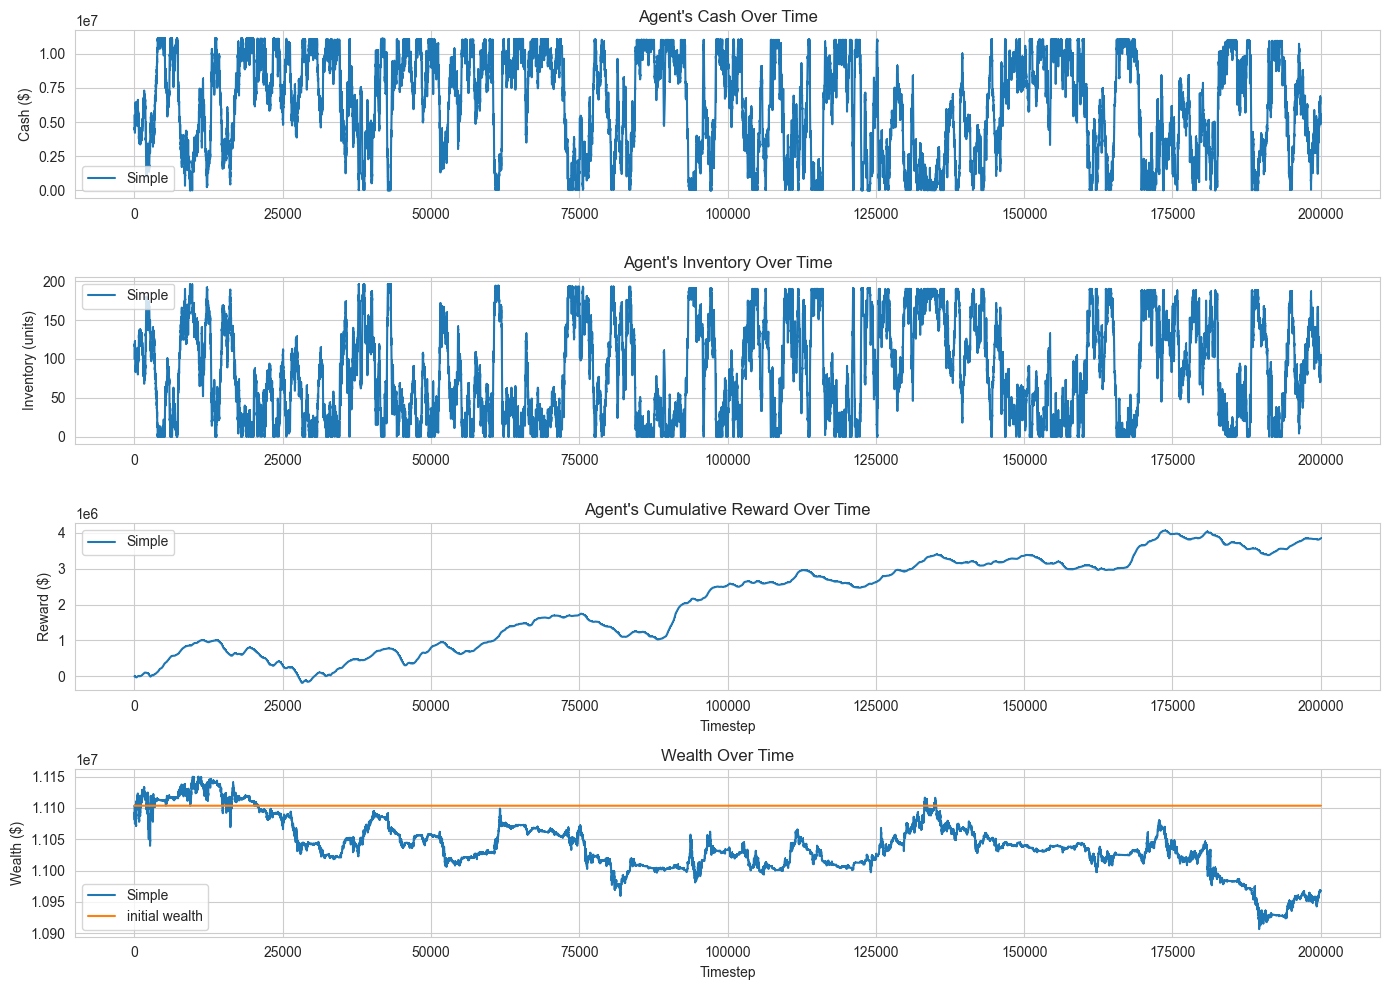

<Figure size 640x480 with 0 Axes>


Evaluating: A-S on BTC (Reward: REWARD_1)
Environment check passed
Initializing A-S...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $11,382,301.00
  P&L:            $278,701.00
  ROI:            2.51%


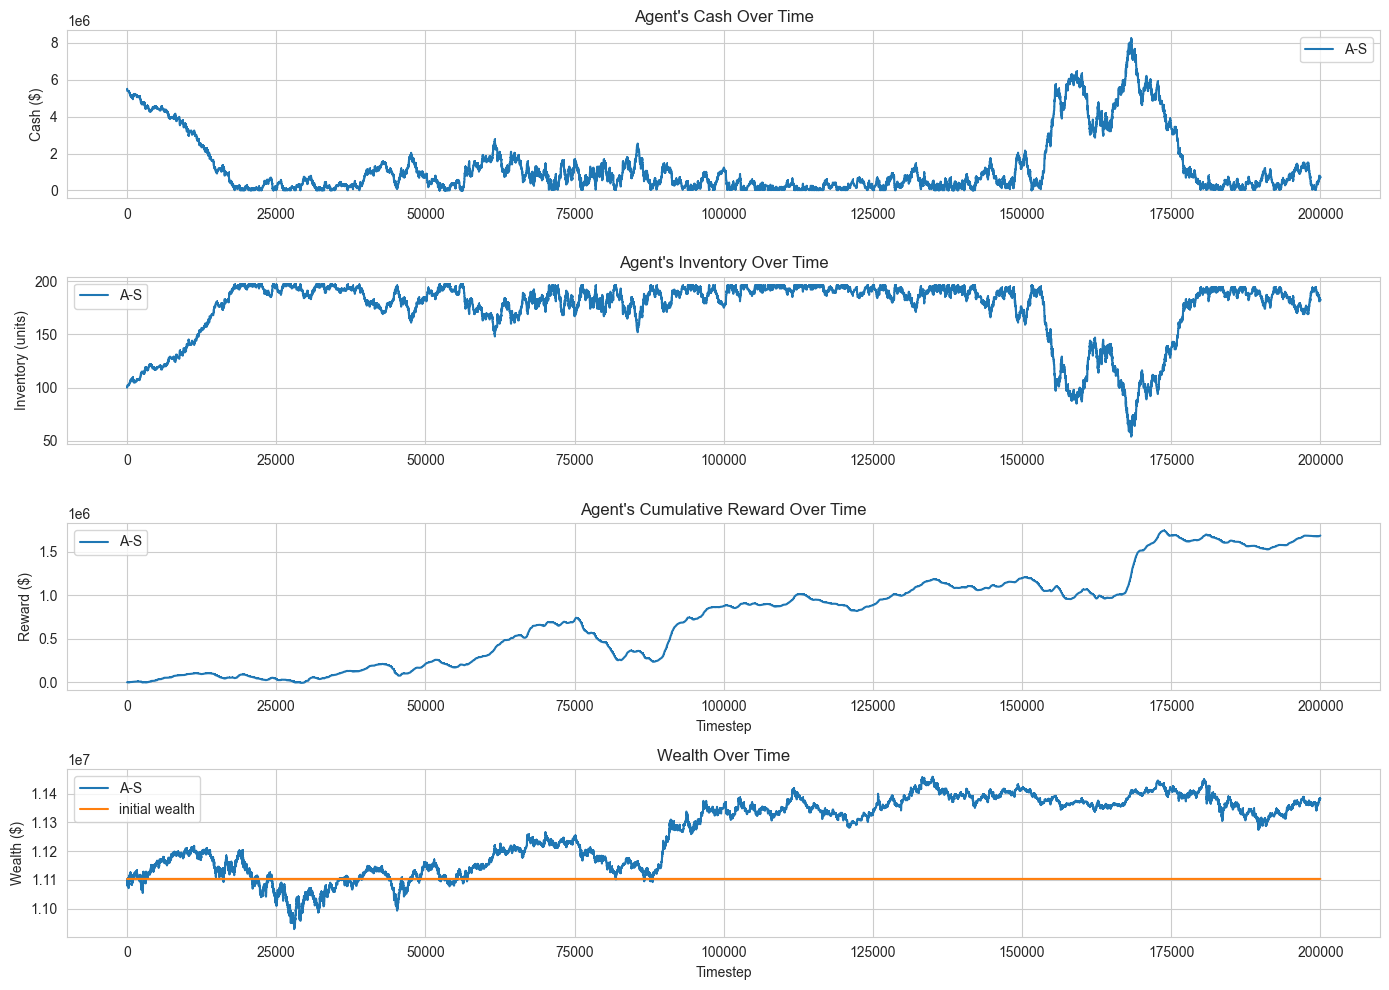

<Figure size 640x480 with 0 Axes>


Evaluating: PPO on BTC (Reward: REWARD_1)
Environment check passed
Initializing PPO...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $11,311,698.06
  P&L:            $208,098.06
  ROI:            1.87%


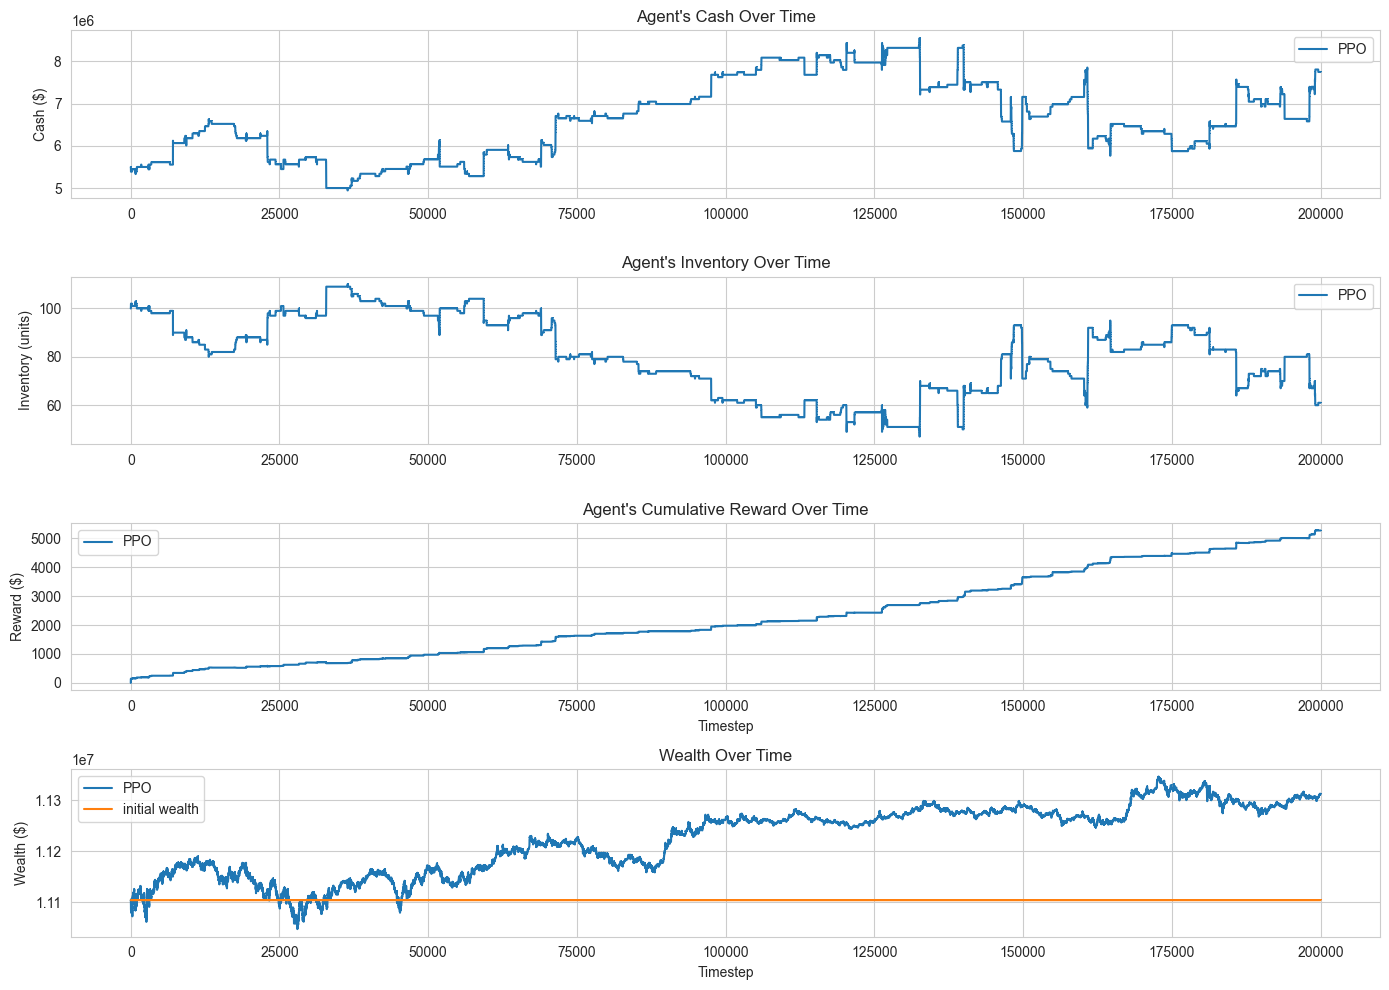

<Figure size 640x480 with 0 Axes>


Evaluating: DQN on BTC (Reward: REWARD_1)
Environment check passed
Initializing DQN...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $11,303,081.10
  P&L:            $199,481.10
  ROI:            1.80%


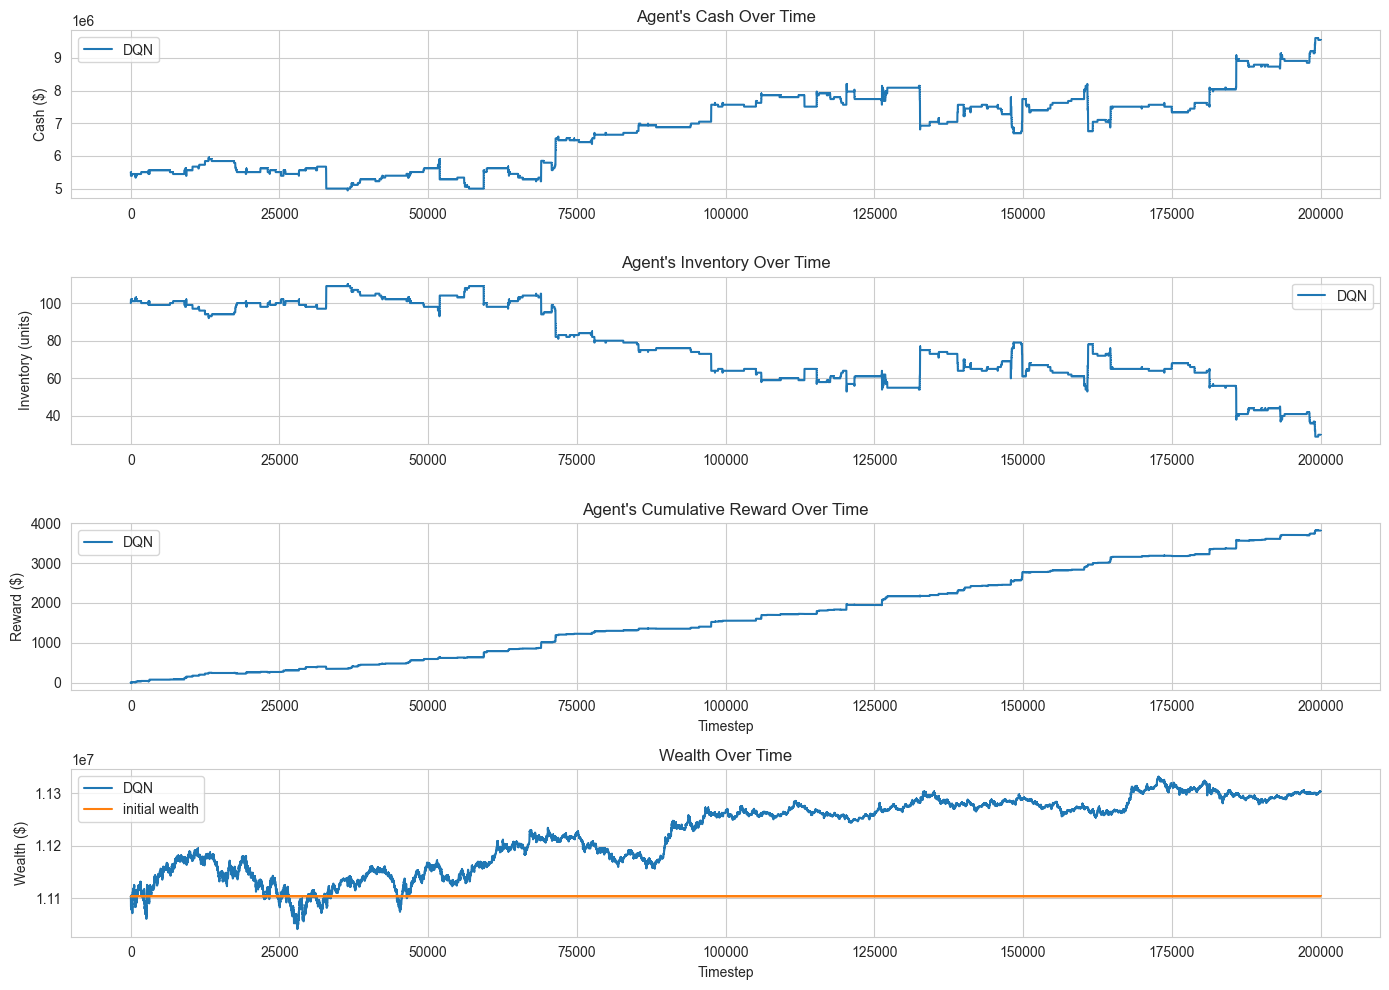

<Figure size 640x480 with 0 Axes>

In [7]:
# Evaluate all agents on BTC with Reward 1
btc_reward1_results = {}

agents_config = [
    (SimpleEnv, SimpleAgent, 'Simple'),
    (ASEnv, ASAgent, 'A-S'),
    (PPOEnv, PPOAgent, 'PPO'),
    (DQNEnv, DQNAgent, 'DQN')
]

for env_class, agent_class, agent_name in agents_config:
    result = evaluate_agent(
        asset='BTC',
        dataset=datasets['BTC'],
        env_class=env_class,
        agent_class=agent_class,
        agent_name=agent_name,
        reward_type=TypeOfReward.REWARD_1,
        config=CONFIG
    )
    btc_reward1_results[agent_name] = result

    # Plot comparative results
    results_list = [result['results']]
    labels = [agent_name]
    plot(results_list, labels)
    plt.suptitle('Bitcoin - Reward Function 1: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

#### Visualization: BTC - Reward 1

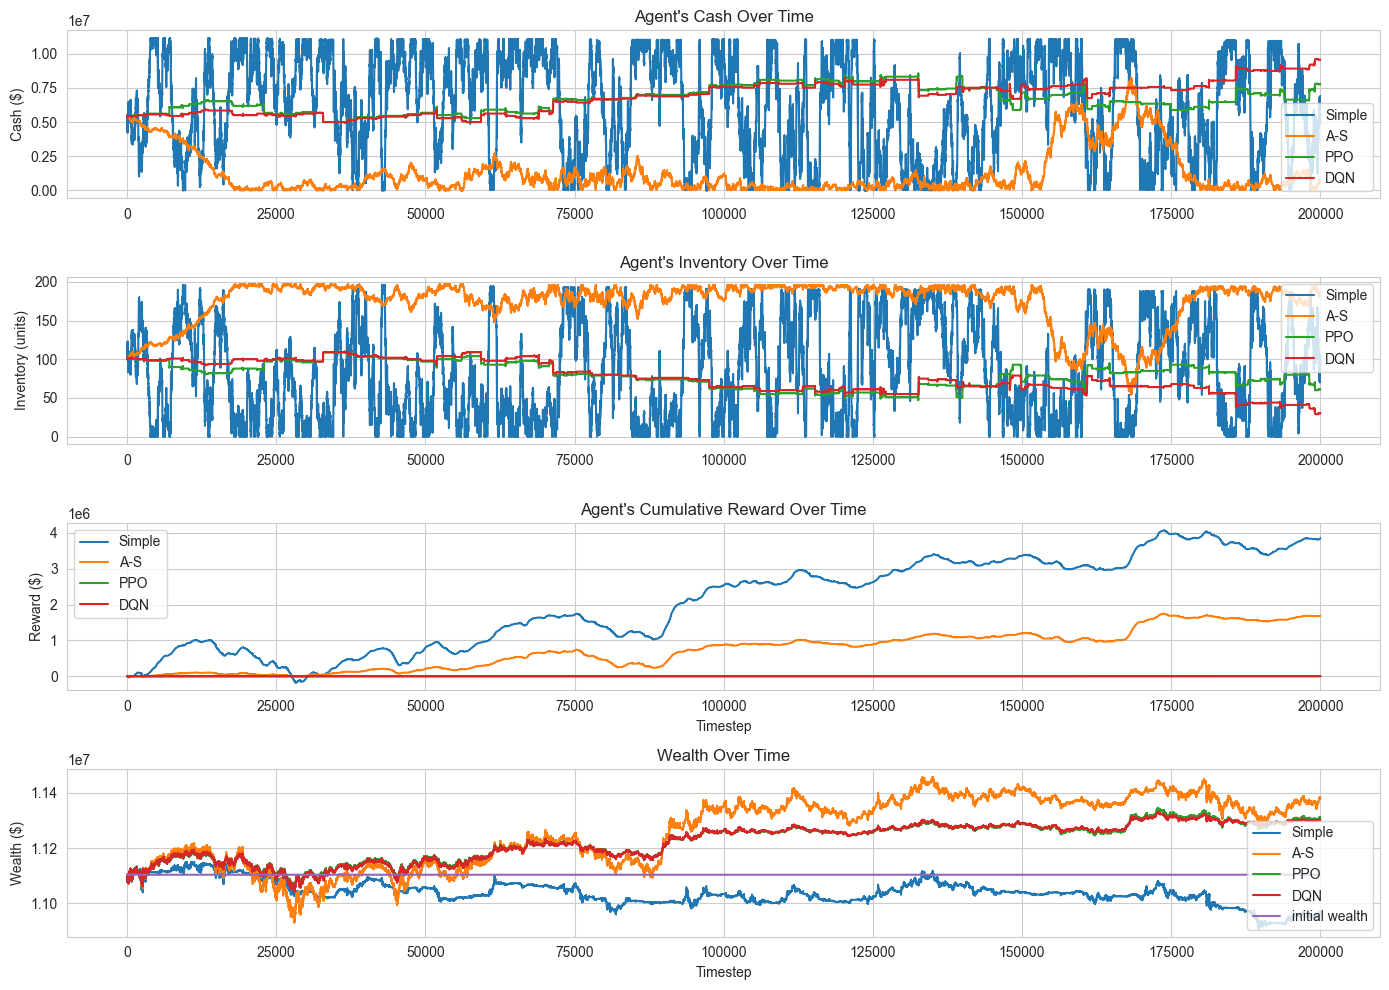

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot comparative results
results_list = [btc_reward1_results[agent]['results'] for agent in ['Simple', 'A-S', 'PPO', 'DQN']]
labels = ['Simple', 'A-S', 'PPO', 'DQN']

plot(results_list, labels)
plt.suptitle('Bitcoin - Reward Function 1: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### 4.2 Reward Function 2: Wealth-Based with Inventory Penalty


Evaluating: Simple on BTC (Reward: REWARD_2)
Environment check passed
Initializing Simple...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $10,967,406.00
  P&L:            $-136,194.00
  ROI:            -1.23%


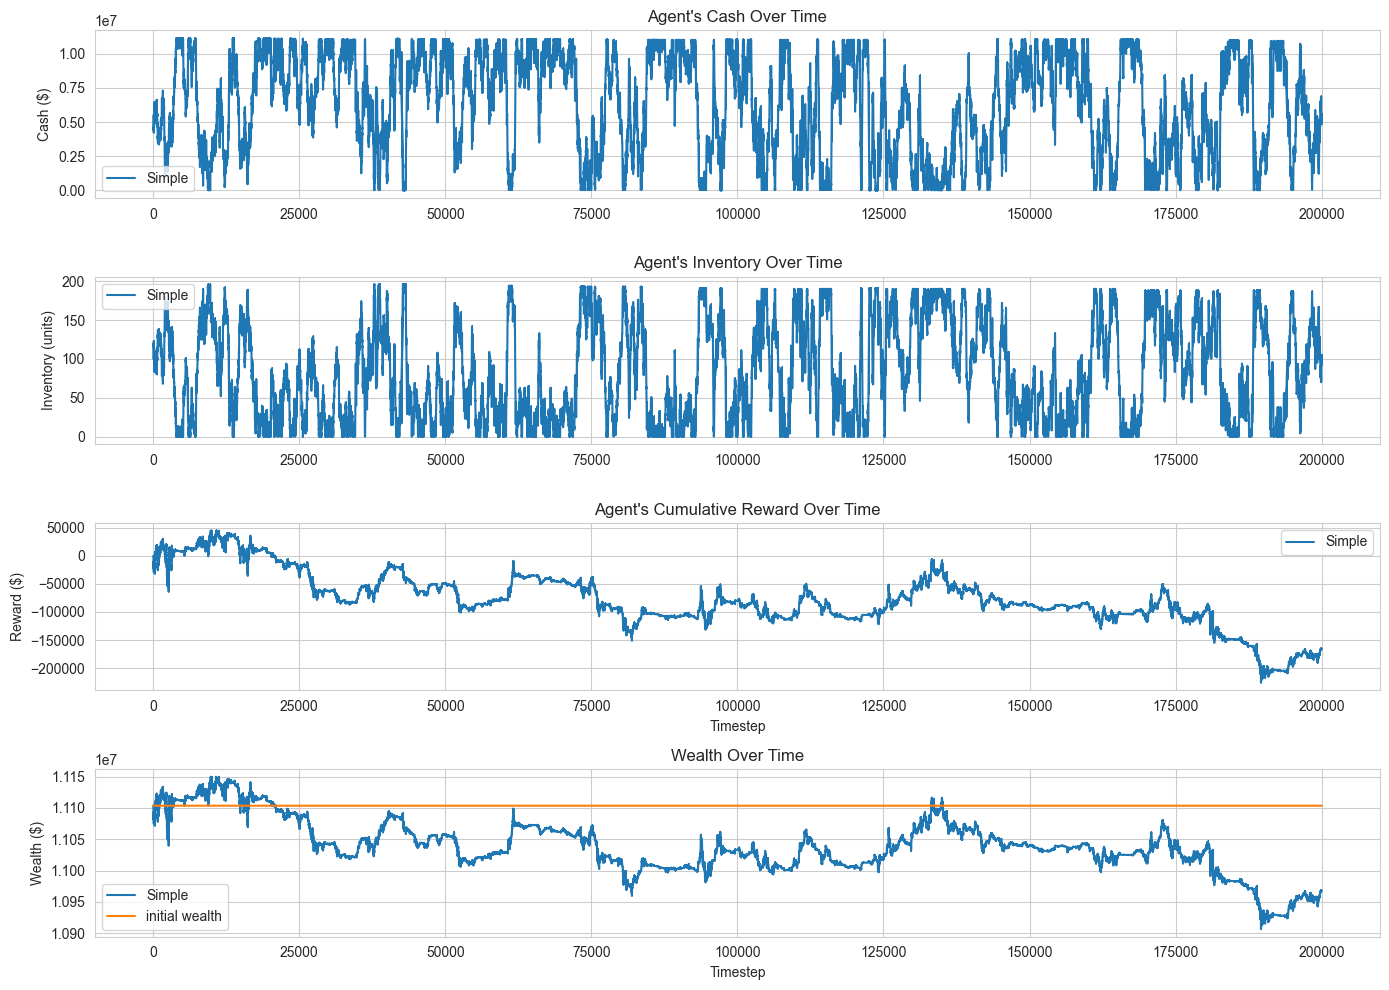

<Figure size 640x480 with 0 Axes>


Evaluating: A-S on BTC (Reward: REWARD_2)
Environment check passed
Initializing A-S...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $11,382,301.00
  P&L:            $278,701.00
  ROI:            2.51%


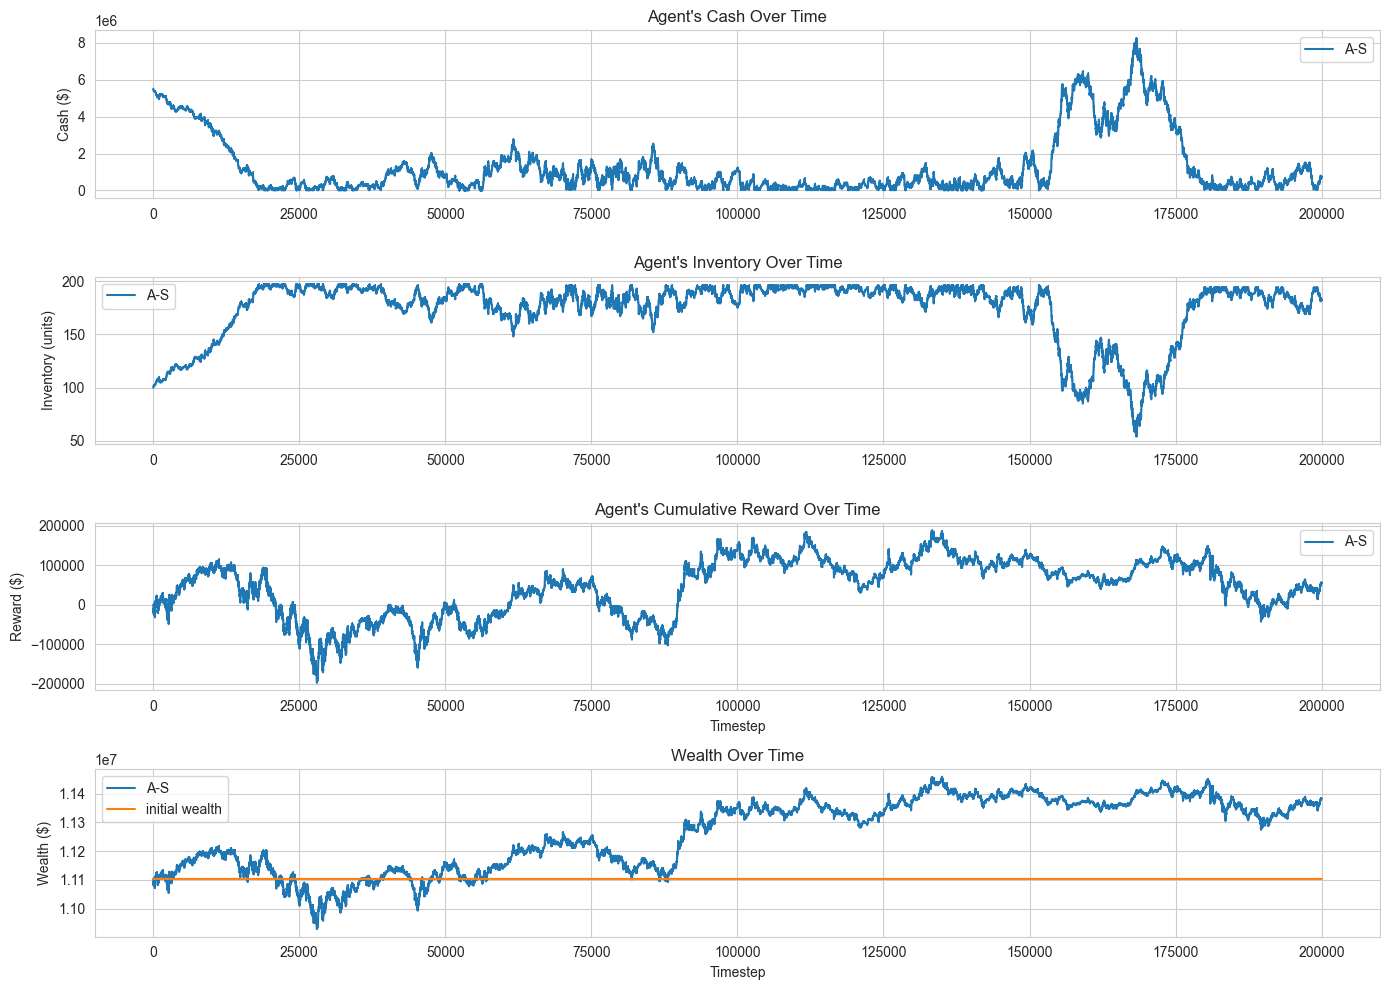

<Figure size 640x480 with 0 Axes>


Evaluating: PPO on BTC (Reward: REWARD_2)
Environment check passed
Initializing PPO...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $10,991,755.88
  P&L:            $-111,844.12
  ROI:            -1.01%


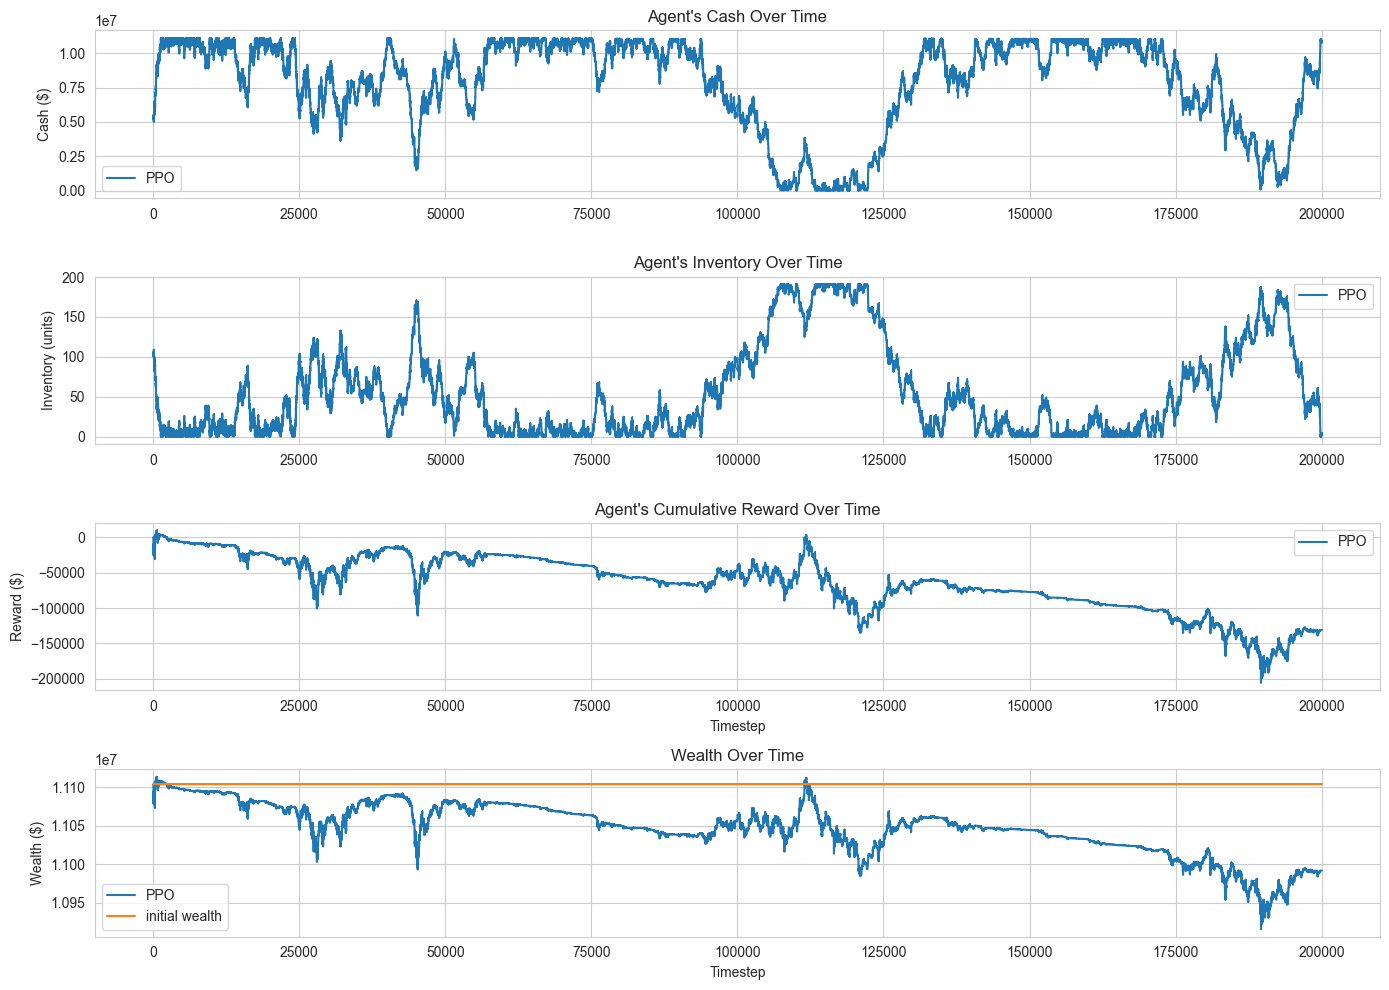

<Figure size 640x480 with 0 Axes>


Evaluating: DQN on BTC (Reward: REWARD_2)
Environment check passed
Initializing DQN...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $11,103,600.00
  Final Wealth:   $10,994,851.10
  P&L:            $-108,748.90
  ROI:            -0.98%


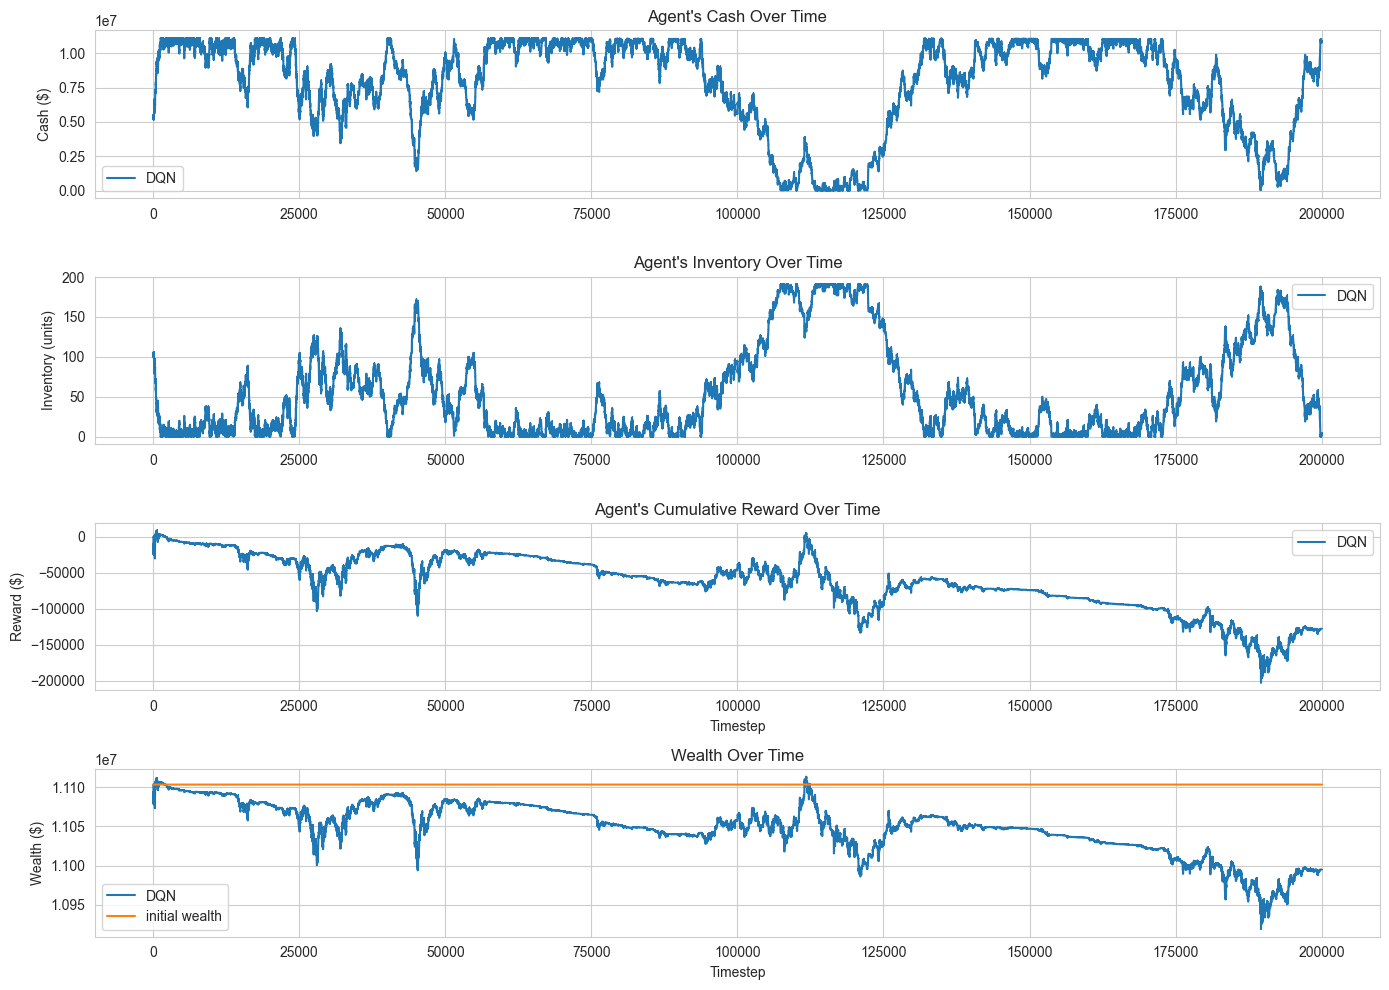

<Figure size 640x480 with 0 Axes>

In [10]:
# Evaluate all agents on BTC with Reward 2
btc_reward2_results = {}

for env_class, agent_class, agent_name in agents_config:
    result = evaluate_agent(
        asset='BTC',
        dataset=datasets['BTC'],
        env_class=env_class,
        agent_class=agent_class,
        agent_name=agent_name,
        reward_type=TypeOfReward.REWARD_2,
        config=CONFIG
    )
    btc_reward2_results[agent_name] = result

    # Plot comparative results
    results_list = [result['results']]
    labels = [agent_name]
    plot(results_list, labels)
    plt.suptitle('Bitcoin - Reward Function 2: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

#### Visualization: BTC - Reward 2

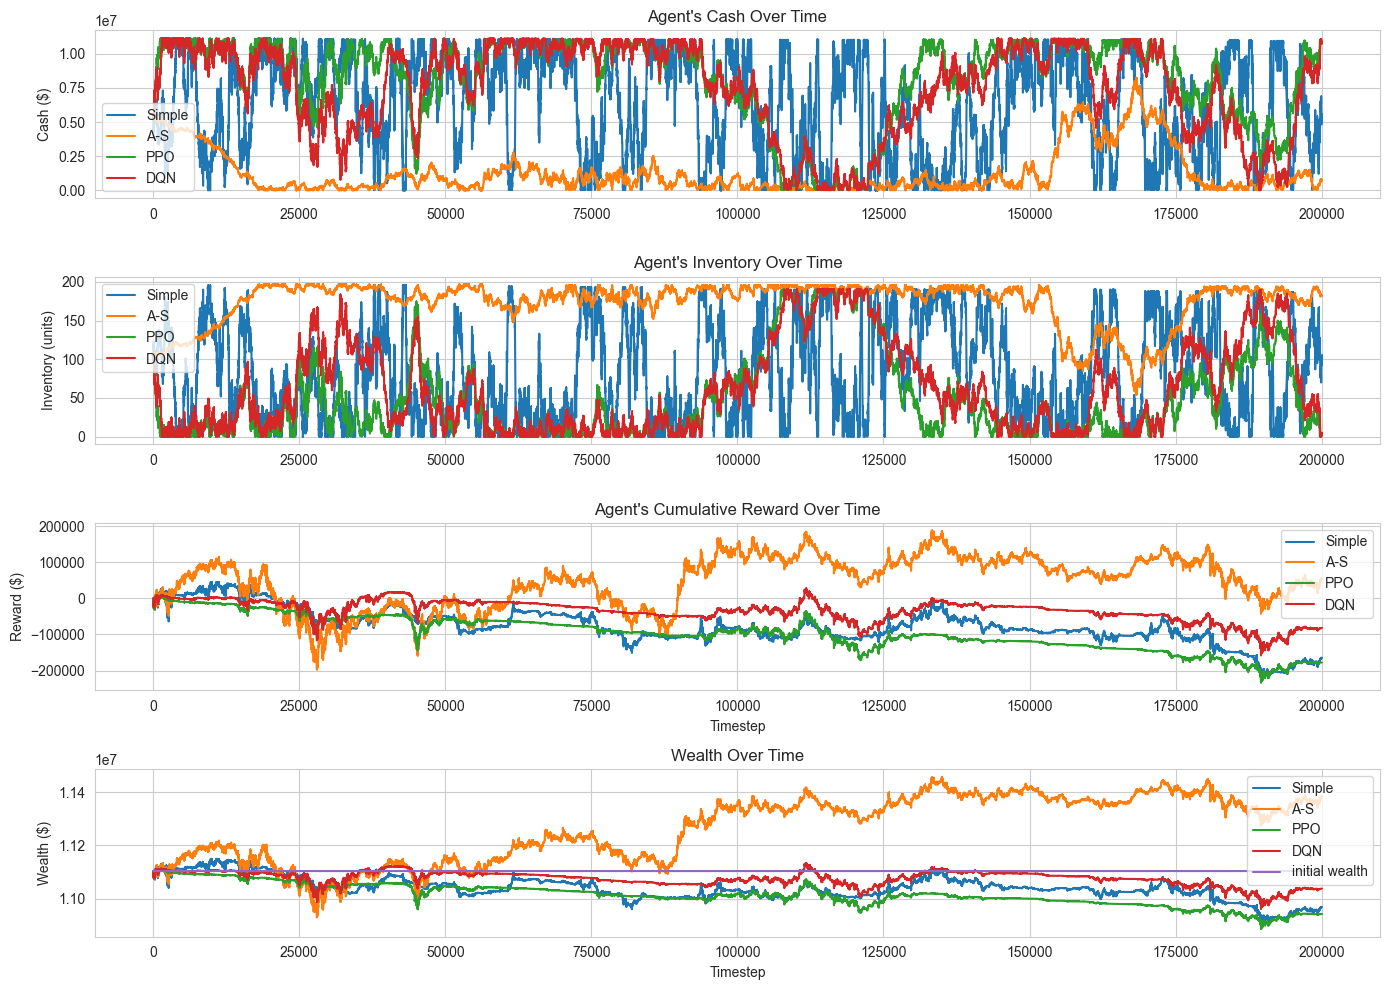

<Figure size 640x480 with 0 Axes>

In [ ]:
results_list = [btc_reward2_results[agent]['results'] for agent in ['Simple', 'A-S', 'PPO', 'DQN']]
labels = ['Simple', 'A-S', 'PPO', 'DQN']

plot(results_list, labels)
plt.suptitle('Bitcoin - Reward Function 2: Wealth-Based with Inventory Penalty', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### Final comparison

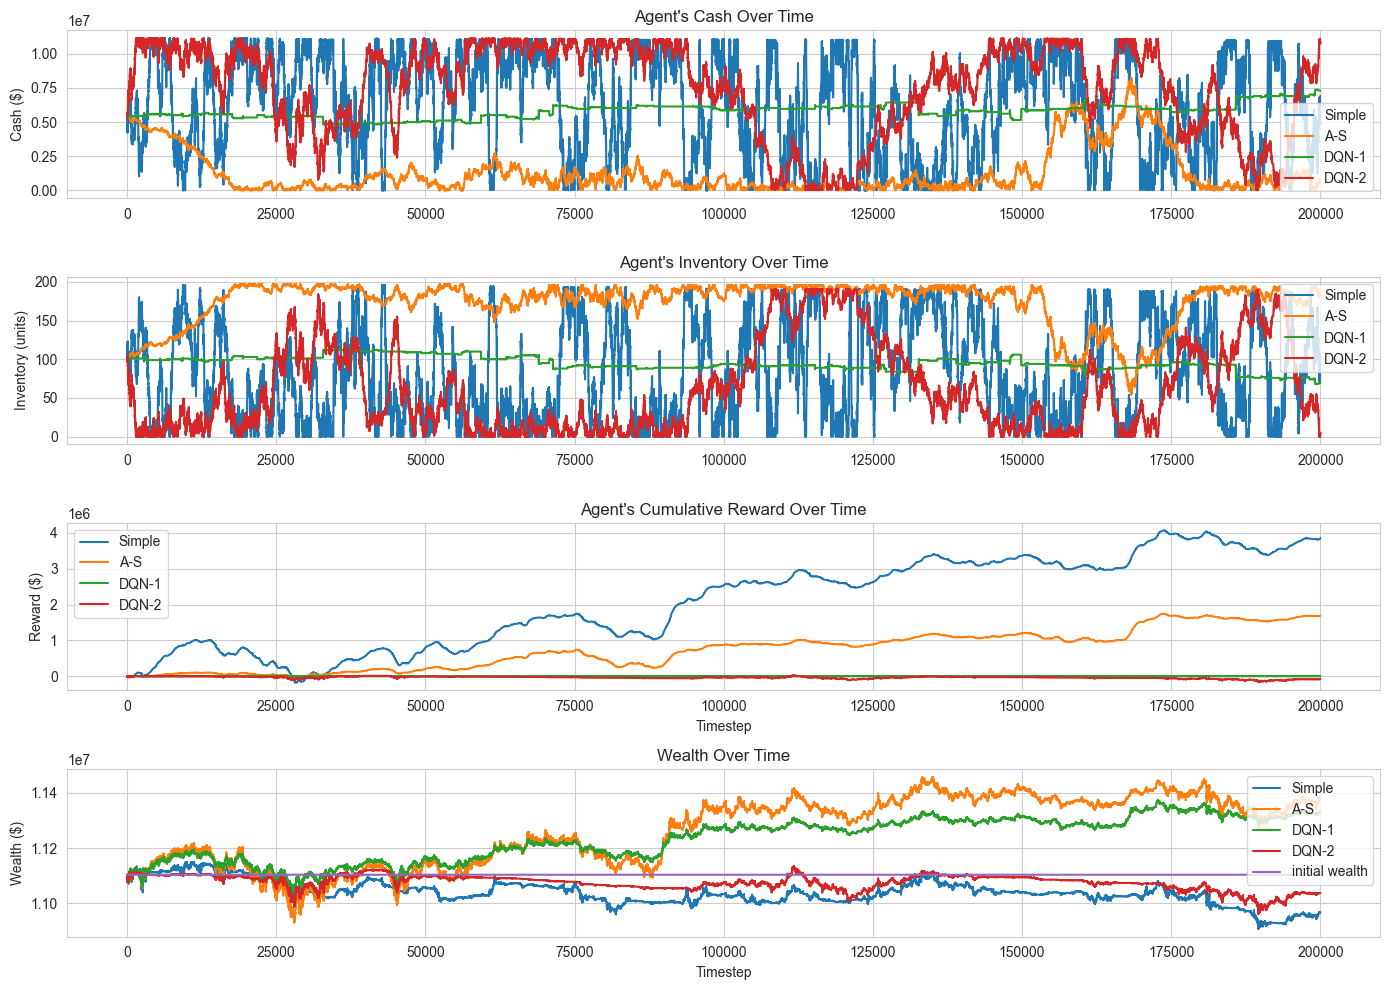

<Figure size 640x480 with 0 Axes>

In [ ]:
results_list = [btc_reward1_results['Simple']['results'], btc_reward1_results['A-S']['results'],  btc_reward1_results['DQN']['results'], btc_reward2_results['DQN']['results']]
labels = ['Simple', 'A-S', 'DQN-1', 'DQN-2']

plot(results_list, labels)
plt.suptitle('Bitcoin - Result', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 5. Experiments: Ethereum (ETH)

### 5.1 Reward Function 1: Rolling Average-Based


Evaluating: Simple on ETH (Reward: REWARD1)
Environment check passed
Initializing Simple...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,767,213.00
  P&L:            $70,114.50
  ROI:            1.23%


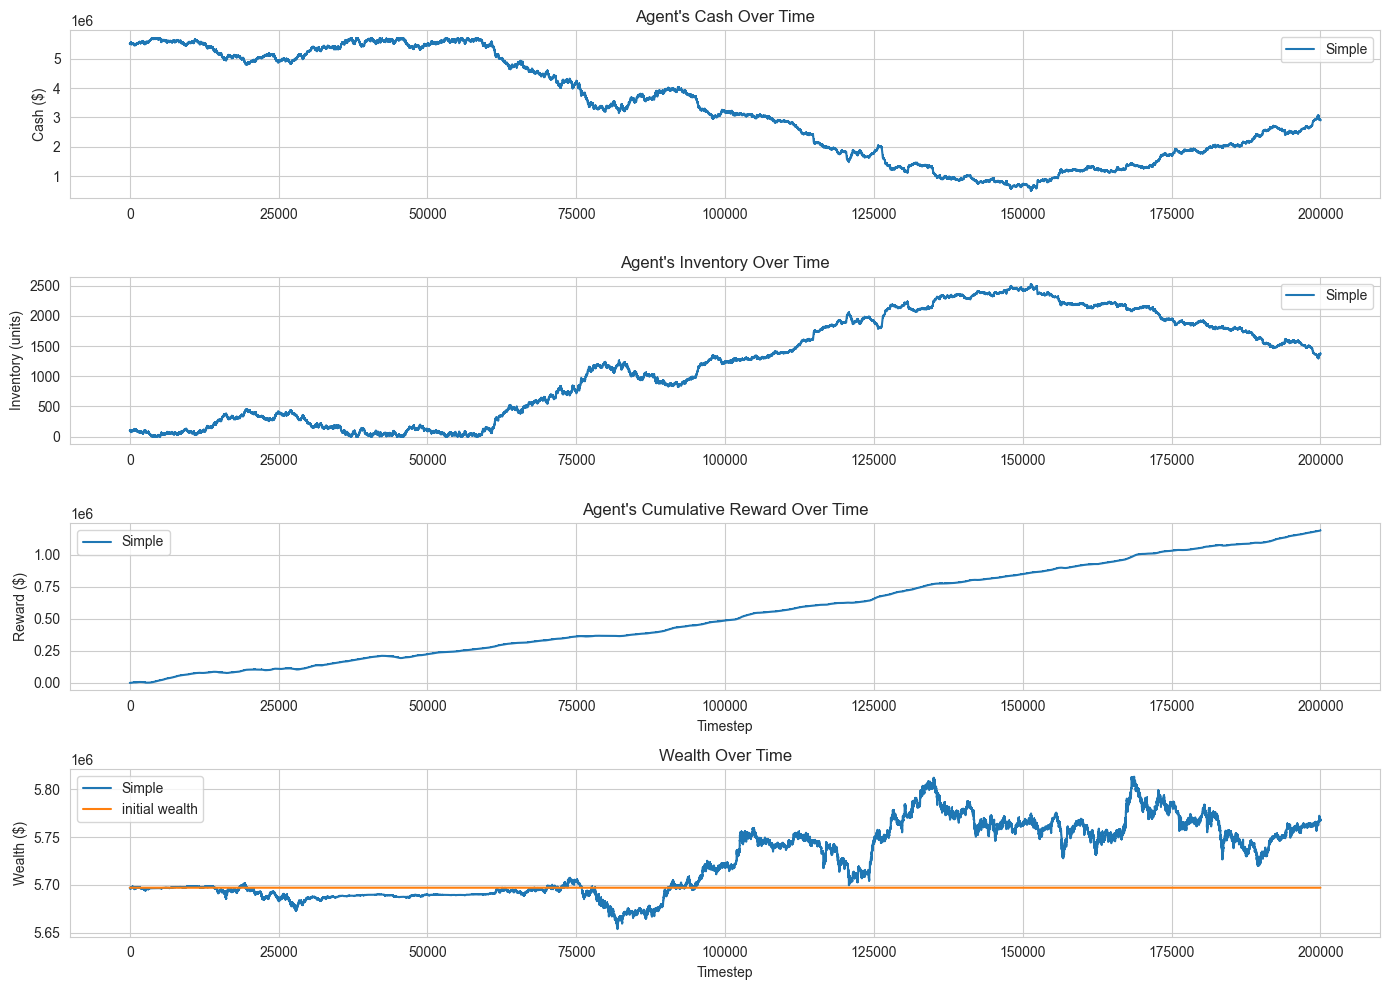

<Figure size 640x480 with 0 Axes>


Evaluating: A-S on ETH (Reward: REWARD1)
Environment check passed
Initializing A-S...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,725,726.50
  P&L:            $28,628.00
  ROI:            0.50%


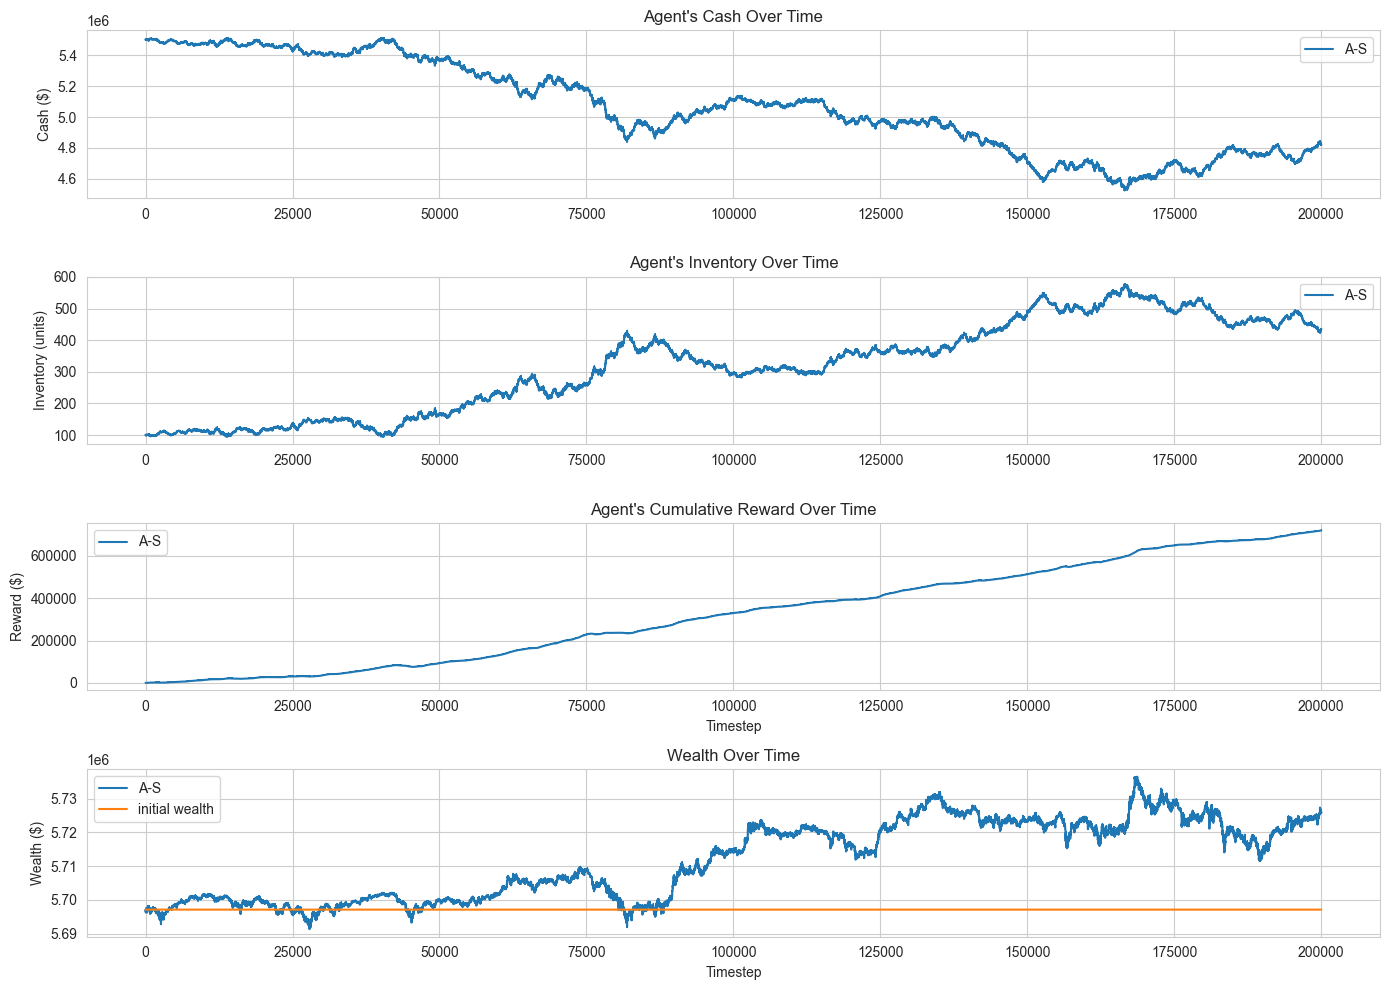

<Figure size 640x480 with 0 Axes>


Evaluating: PPO on ETH (Reward: REWARD1)
Environment check passed
Initializing PPO...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,702,621.70
  P&L:            $5,523.20
  ROI:            0.10%


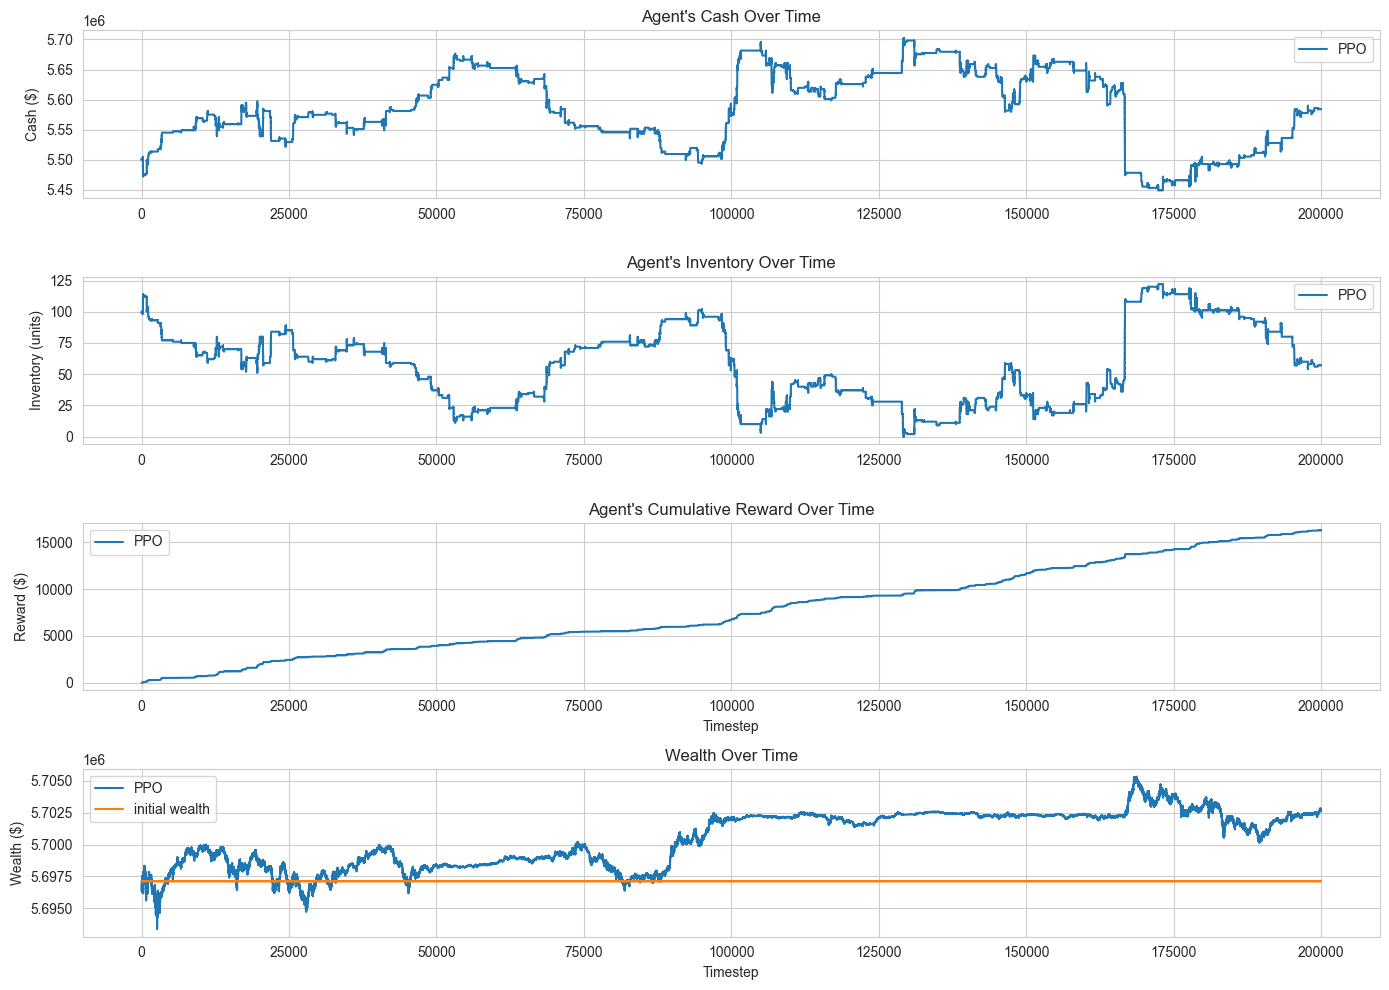

<Figure size 640x480 with 0 Axes>


Evaluating: DQN on ETH (Reward: REWARD1)
Environment check passed
Initializing DQN...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,701,616.82
  P&L:            $4,518.32
  ROI:            0.08%


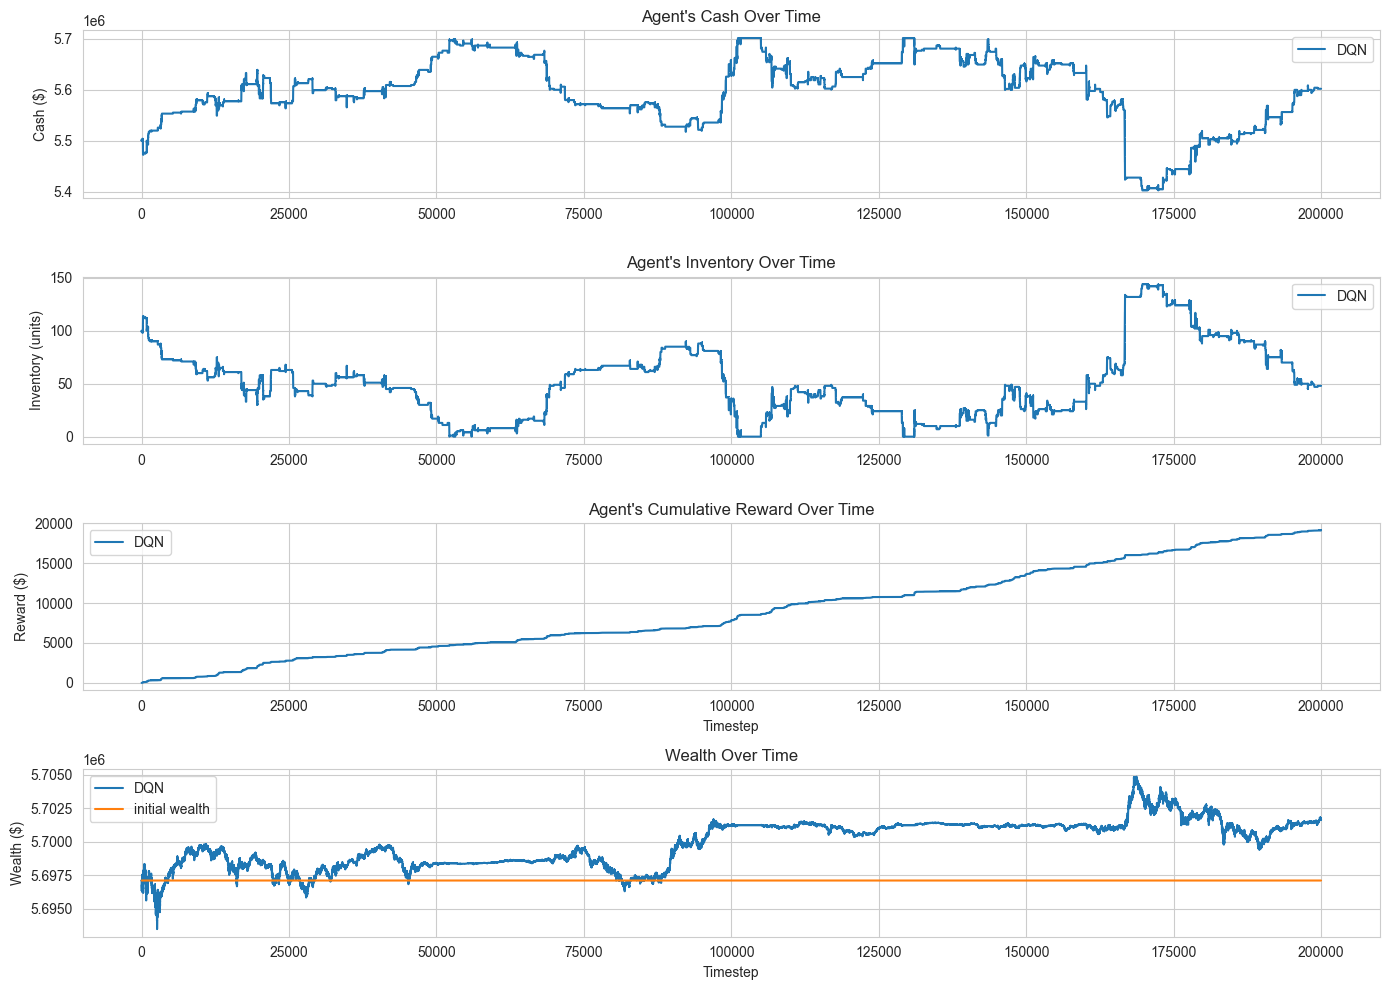

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluate all agents on ETH with Reward 1
eth_reward1_results = {}

for env_class, agent_class, agent_name in agents_config:
    result = evaluate_agent(
        asset='ETH',
        dataset=datasets['ETH'],
        env_class=env_class,
        agent_class=agent_class,
        agent_name=agent_name,
        reward_type=TypeOfReward.Reward_1,
        config=CONFIG
    )
    eth_reward1_results[agent_name] = result

    # Plot comparative results
    results_list = [result['results']]
    labels = [agent_name]
    plot(results_list, labels)
    plt.suptitle('ETH - Reward Function 1: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

#### Visualization: ETH - Reward 1

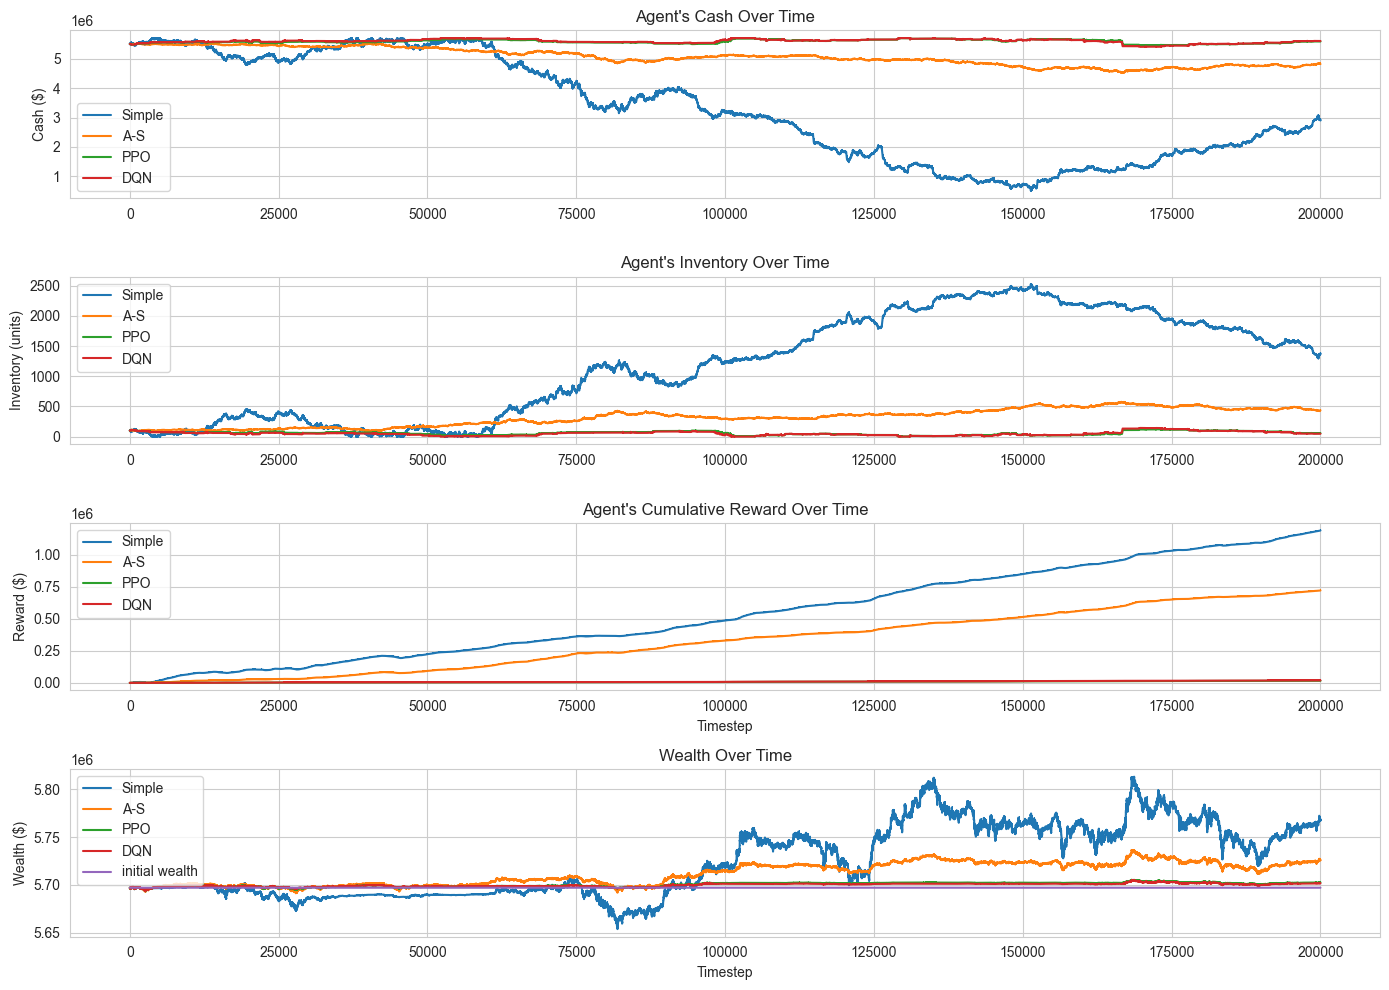

<Figure size 640x480 with 0 Axes>

In [ ]:
results_list = [eth_reward1_results[agent]['results'] for agent in ['Simple', 'A-S', 'PPO', 'DQN']]
labels = ['Simple', 'A-S', 'PPO', 'DQN']

plot(results_list, labels)
plt.suptitle('Ethereum - Reward Function 1: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### 5.2 Reward Function 2: Wealth-Based with Inventory Penalty


Evaluating: Simple on ETH (Reward: REWARD2)
Environment check passed
Initializing Simple...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,767,213.00
  P&L:            $70,114.50
  ROI:            1.23%


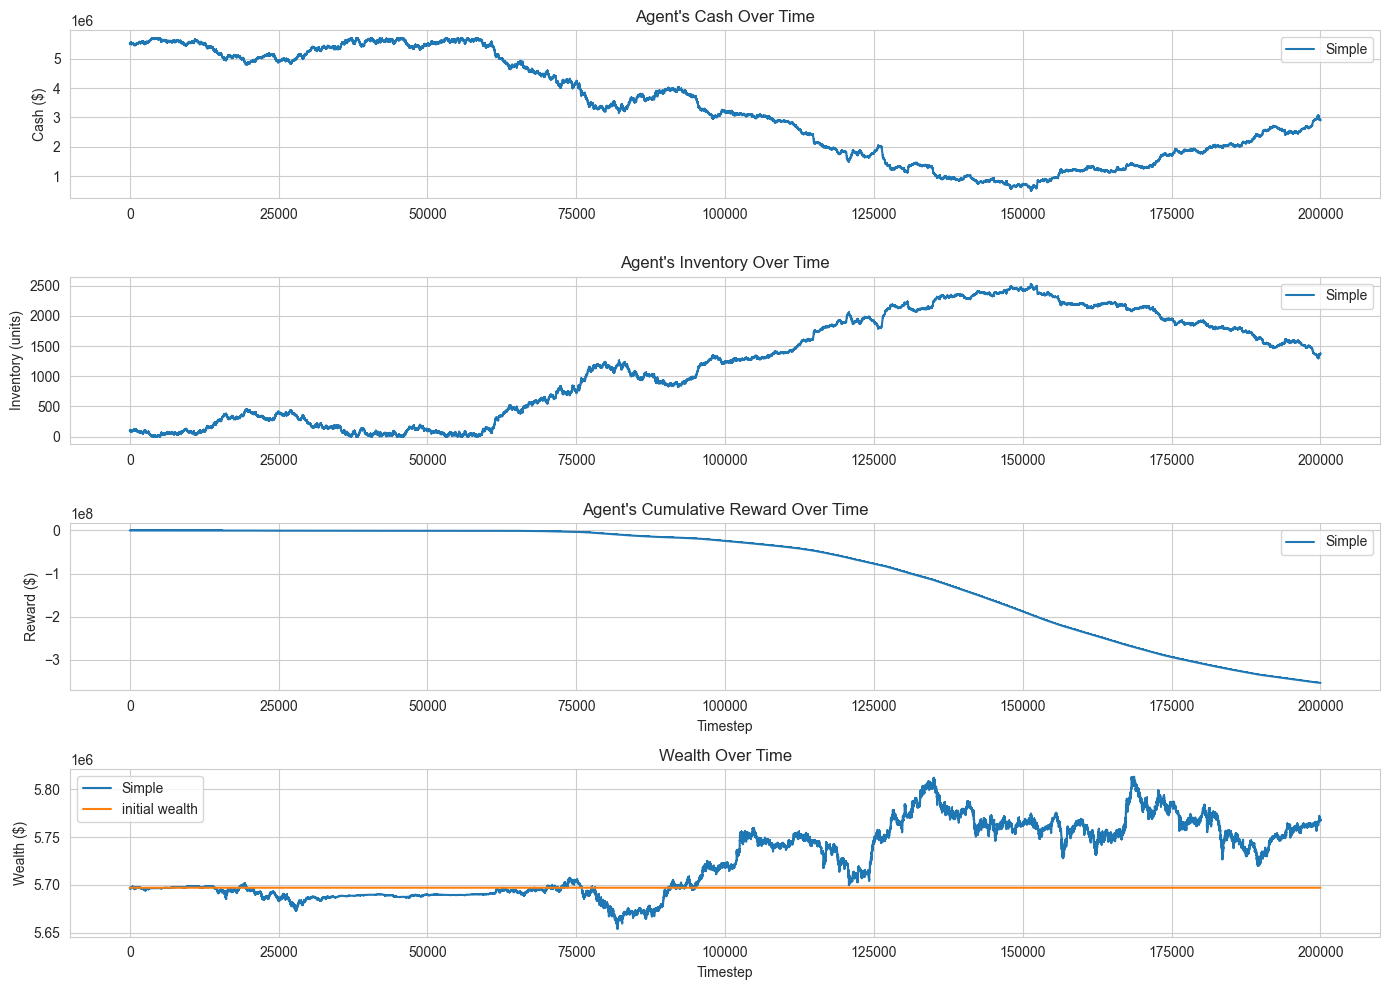

<Figure size 640x480 with 0 Axes>


Evaluating: A-S on ETH (Reward: REWARD2)
Environment check passed
Initializing A-S...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,725,726.50
  P&L:            $28,628.00
  ROI:            0.50%


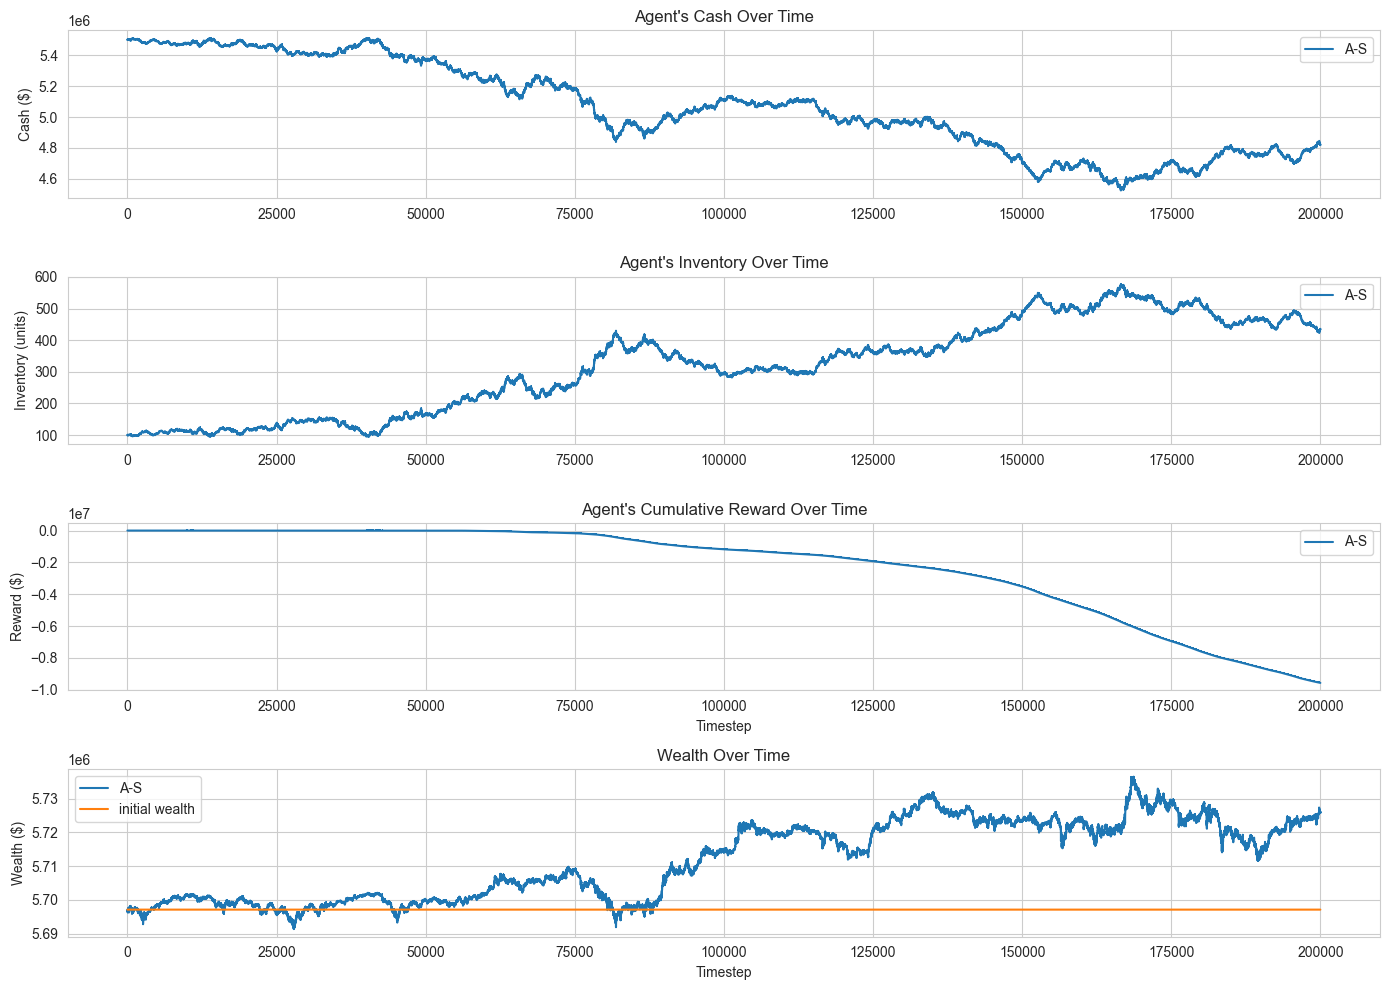

<Figure size 640x480 with 0 Axes>


Evaluating: PPO on ETH (Reward: REWARD2)
Environment check passed
Initializing PPO...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.58
  Final Wealth:   $5,688,319.21
  P&L:            $-8,779.38
  ROI:            -0.15%


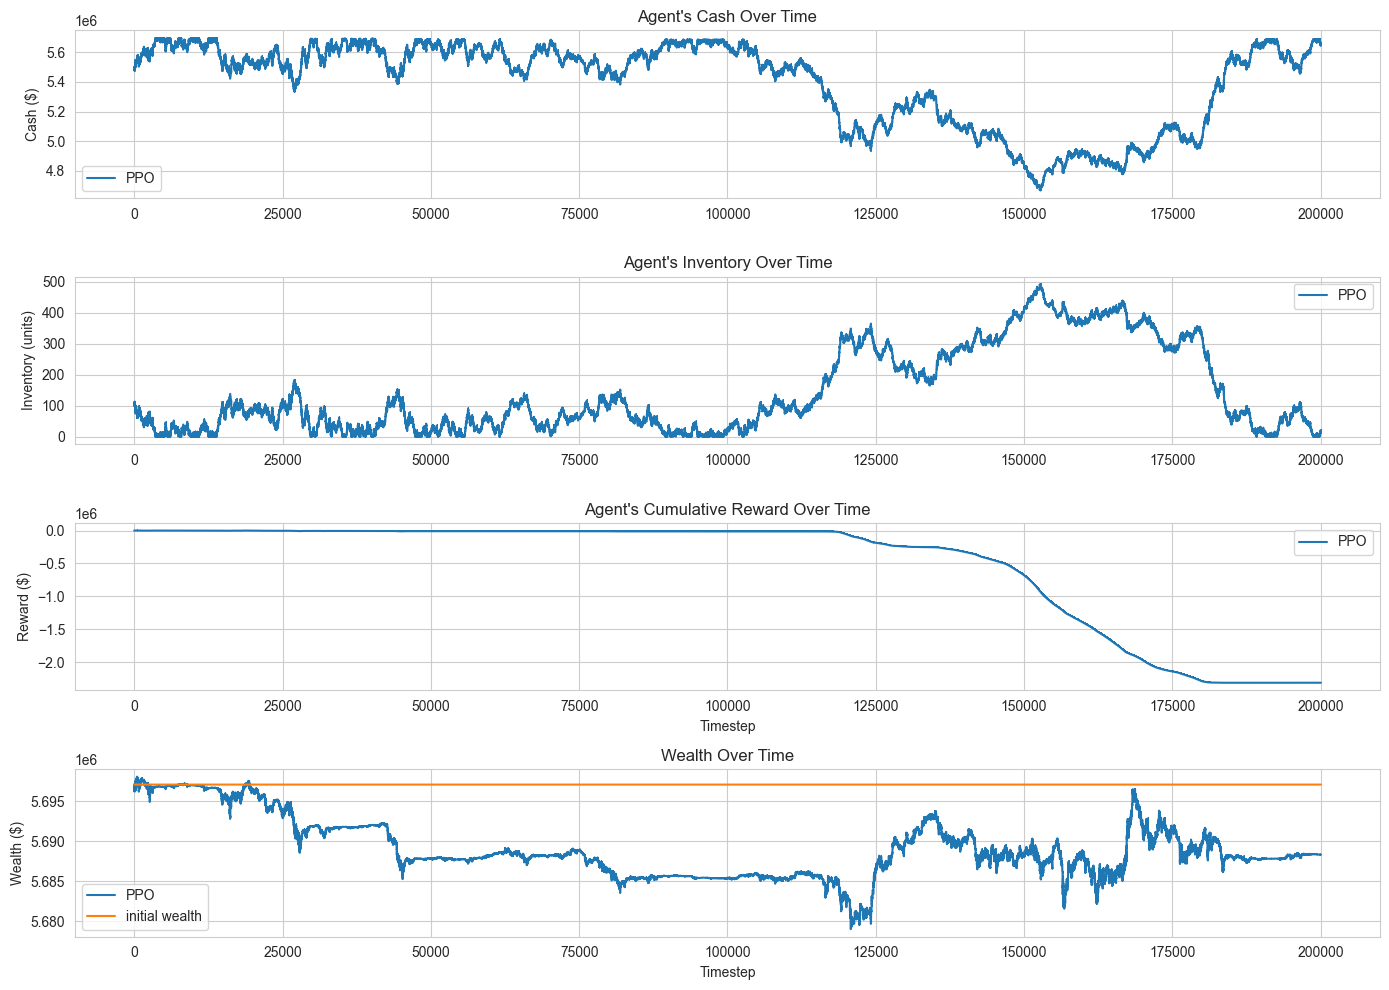

<Figure size 640x480 with 0 Axes>


Evaluating: DQN on ETH (Reward: REWARD2)
Environment check passed
Initializing DQN...
Running evaluation for 200,000 timesteps...

 Evaluation complete
  Initial Wealth: $5,697,098.50
  Final Wealth:   $5,711,076.65
  P&L:            $13,978.15
  ROI:            0.25%


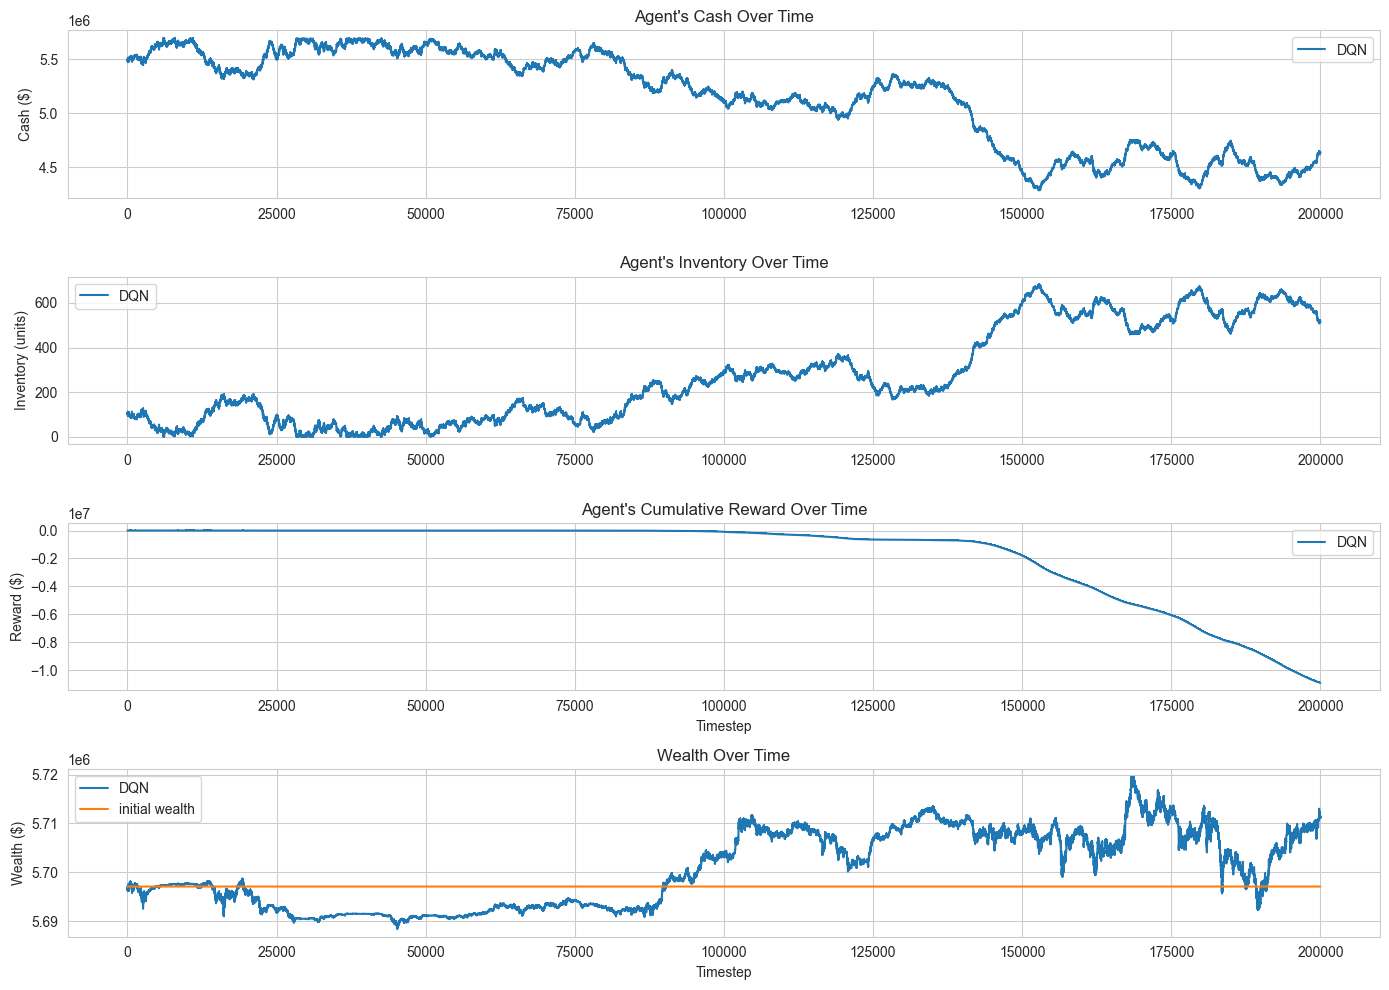

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluate all agents on ETH with Reward 2
eth_reward2_results = {}

for env_class, agent_class, agent_name in agents_config:
    result = evaluate_agent(
        asset='ETH',
        dataset=datasets['ETH'],
        env_class=env_class,
        agent_class=agent_class,
        agent_name=agent_name,
        reward_type=TypeOfReward.REWARD2,
        config=CONFIG
    )
    eth_reward2_results[agent_name] = result

    # Plot comparative results
    results_list = [result['results']]
    labels = [agent_name]
    plot(results_list, labels)
    plt.suptitle('ETH - Reward Function 2: Rolling Average-Based', fontsize=14, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

#### Visualization: ETH - Reward 2

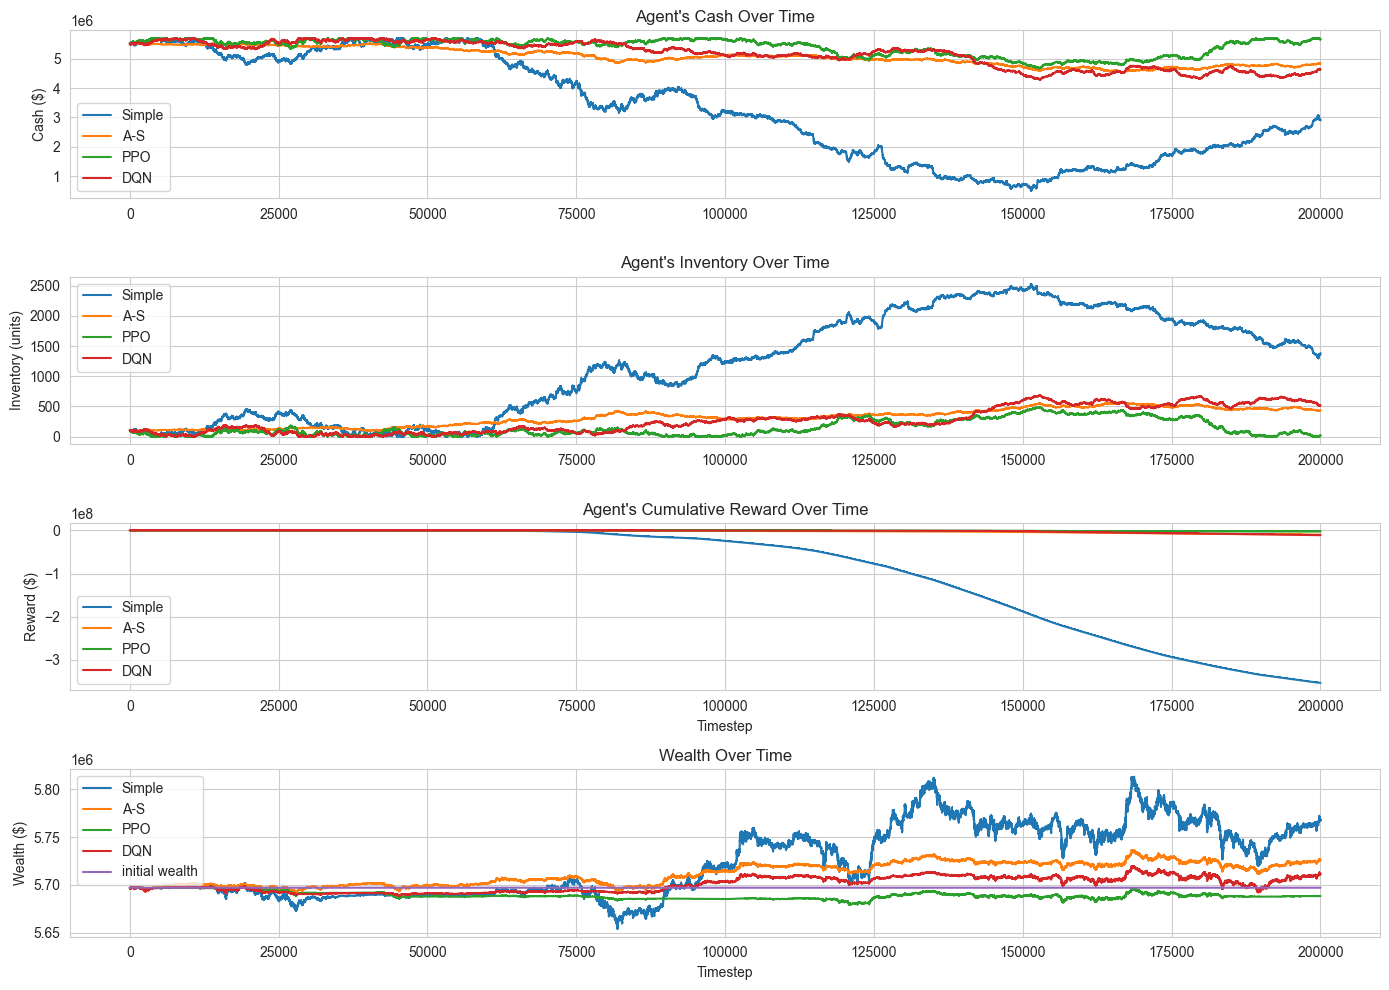

<Figure size 640x480 with 0 Axes>

In [ ]:
results_list = [eth_reward2_results[agent]['results'] for agent in ['Simple', 'A-S', 'PPO', 'DQN']]
labels = ['Simple', 'A-S', 'PPO', 'DQN']

plot(results_list, labels)
plt.suptitle('Ethereum - Reward Function 2: Wealth-Based with Inventory Penalty', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### Final comparison

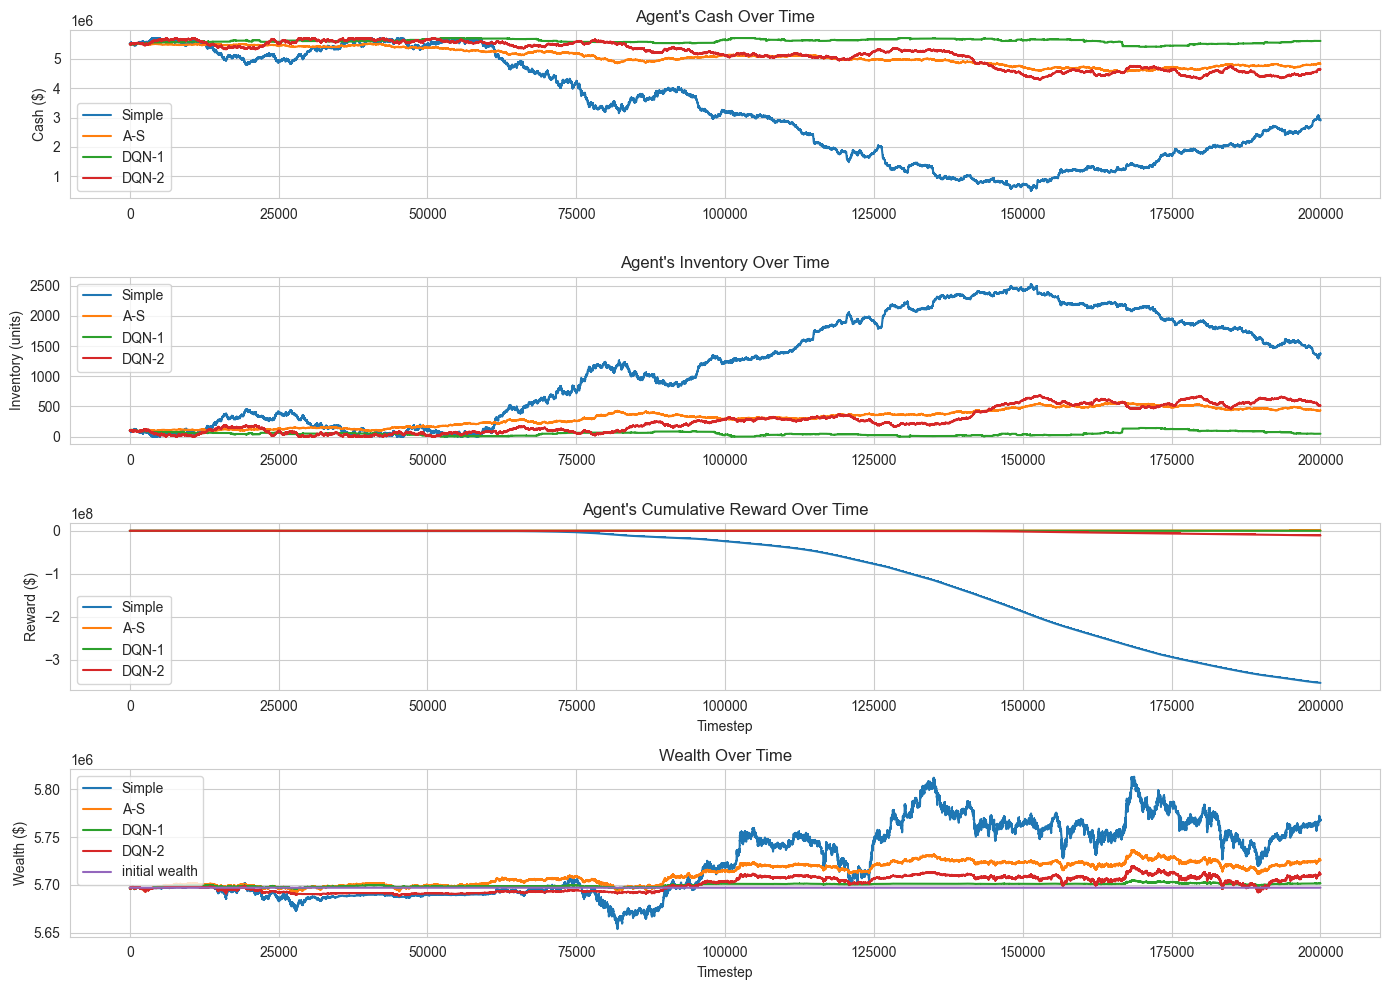

<Figure size 640x480 with 0 Axes>

In [ ]:
results_list = [eth_reward2_results['Simple']['results'], eth_reward1_results['A-S']['results'],  eth_reward1_results['DQN']['results'], eth_reward2_results['DQN']['results']]
labels = ['Simple', 'A-S', 'DQN-1', 'DQN-2']

plot(results_list, labels)
plt.suptitle('Bitcoin - Result', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 6. Cross-Asset Comparison

### 6.1 Side-by-Side Comparison: BTC vs ETH (Reward 1)

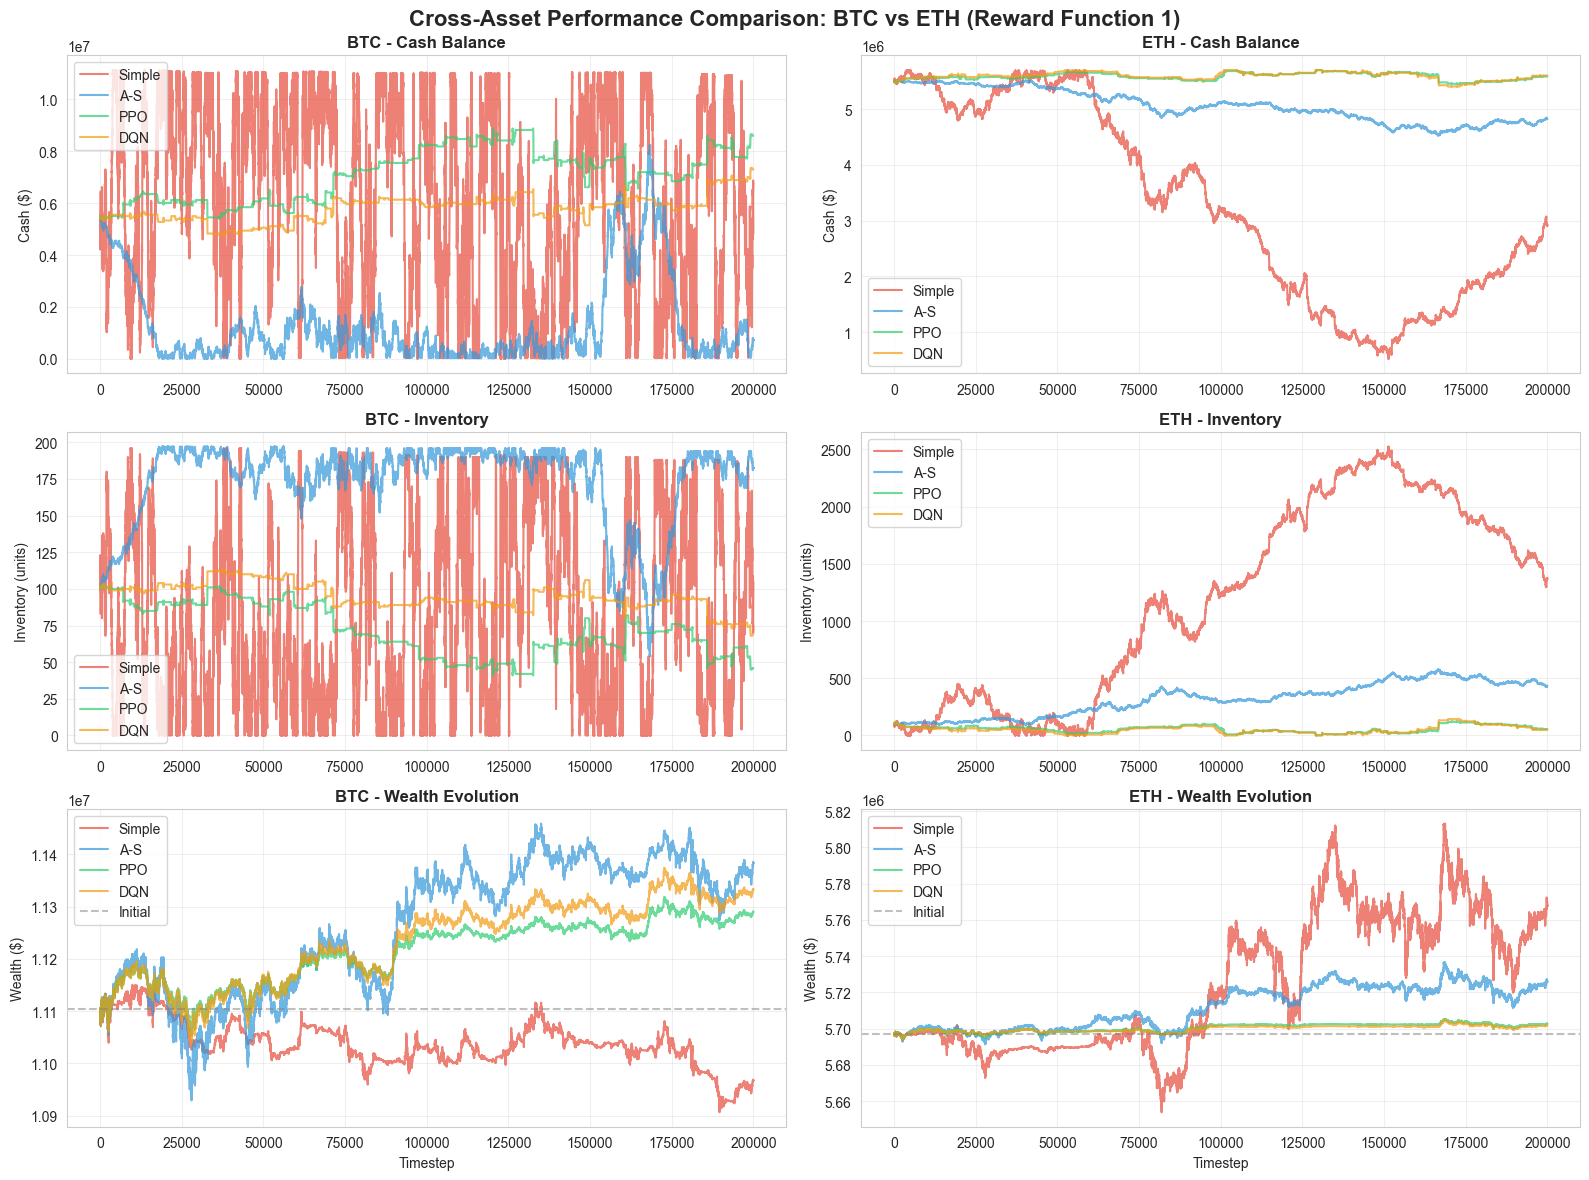

Figure saved: cross_asset_comparison_reward1.png


In [ ]:
# Create comprehensive cross-asset visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Cross-Asset Performance Comparison: BTC vs ETH (Reward Function 1)', 
             fontsize=16, fontweight='bold')

assets_results = [('BTC', btc_reward1_results), ('ETH', eth_reward1_results)]
colors = {'Simple': '#e74c3c', 'A-S': '#3498db', 'PPO': '#2ecc71', 'DQN': '#f39c12'}

for col, (asset, results_dict) in enumerate(assets_results):
    # Cash
    ax = axes[0, col]
    for agent_name, color in colors.items():
        cash = results_dict[agent_name]['results']['cash']
        ax.plot(cash, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Cash Balance', fontweight='bold')
    ax.set_ylabel('Cash ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Inventory
    ax = axes[1, col]
    for agent_name, color in colors.items():
        inventory = results_dict[agent_name]['results']['inventory']
        ax.plot(inventory, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Inventory', fontweight='bold')
    ax.set_ylabel('Inventory (units)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Wealth
    ax = axes[2, col]
    for agent_name, color in colors.items():
        wealth = results_dict[agent_name]['results']['wealth']
        ax.plot(wealth, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    initial_wealth = results_dict['PPO']['results']['wealth'][0]
    ax.axhline(y=initial_wealth, color='gray', linestyle='--', alpha=0.5, label='Initial')
    ax.set_title(f'{asset} - Wealth Evolution', fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Wealth ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_asset_comparison_reward1.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: cross_asset_comparison_reward1.png")

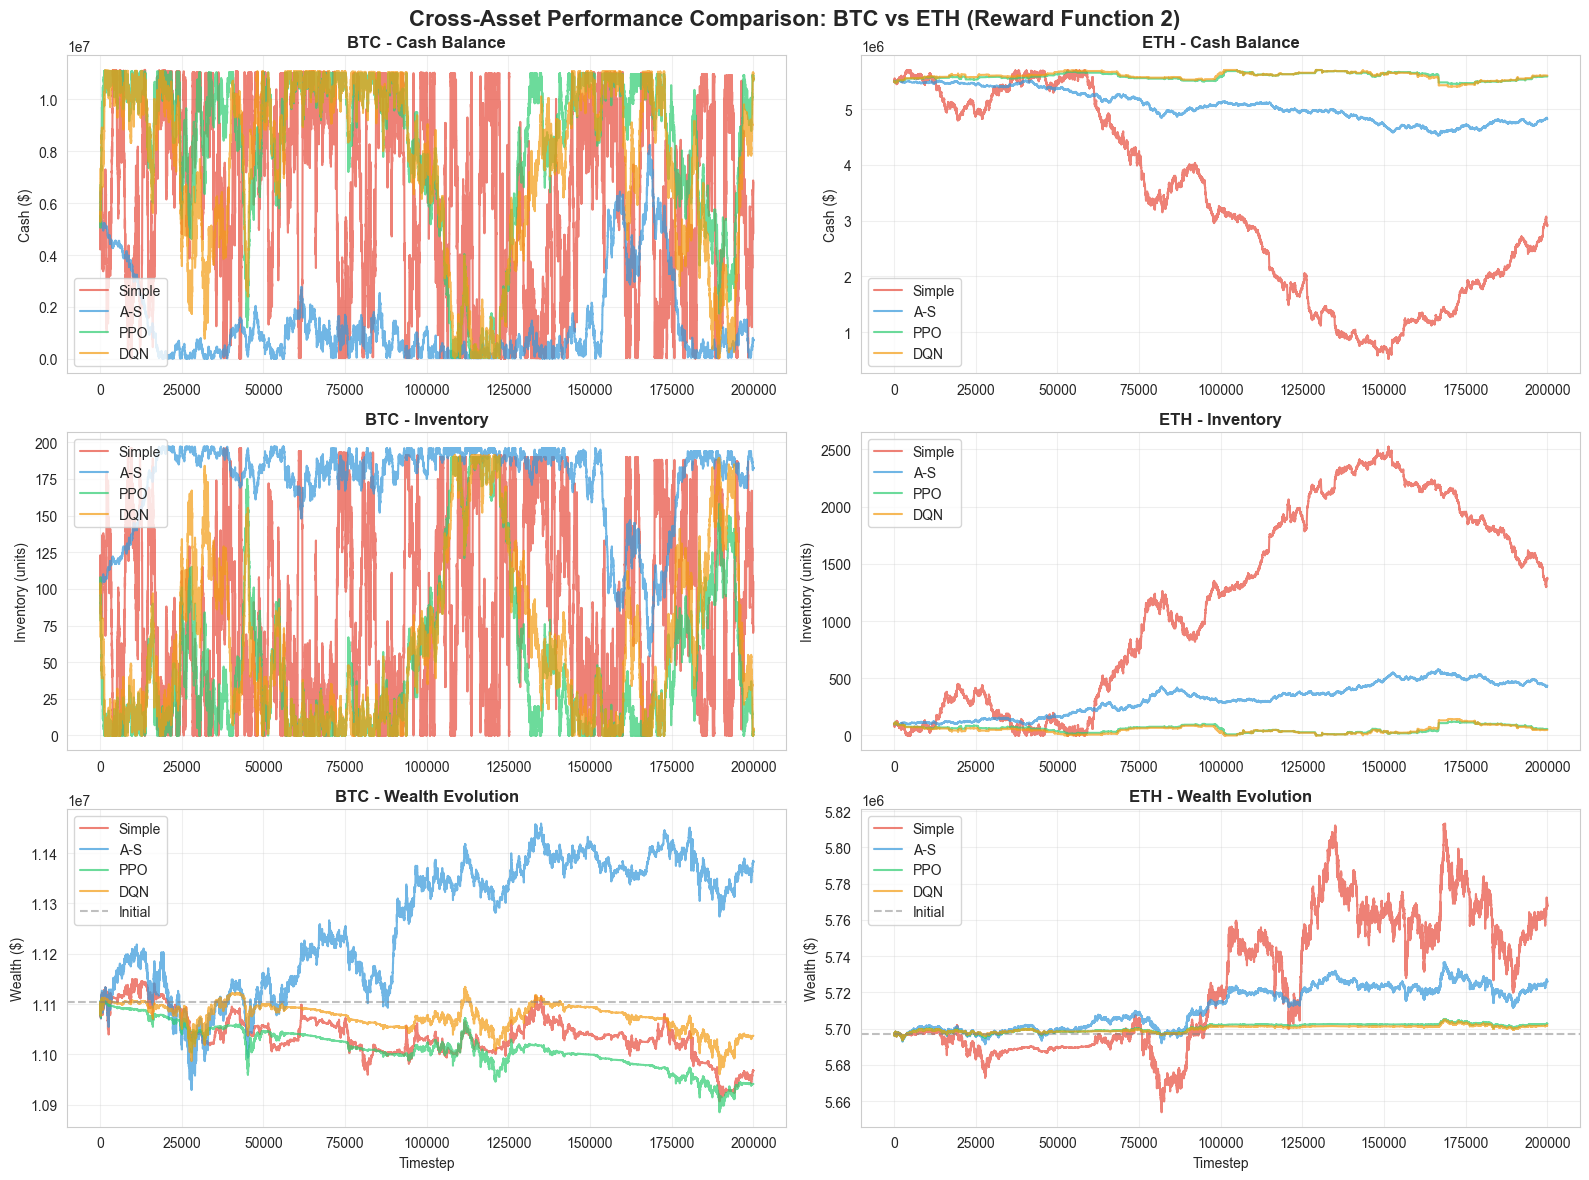

Figure saved: cross_asset_comparison_reward2.png


In [ ]:
# Create comprehensive cross-asset visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Cross-Asset Performance Comparison: BTC vs ETH (Reward Function 2)', 
             fontsize=16, fontweight='bold')

assets_results = [('BTC', btc_reward2_results), ('ETH', eth_reward1_results)]
colors = {'Simple': '#e74c3c', 'A-S': '#3498db', 'PPO': '#2ecc71', 'DQN': '#f39c12'}

for col, (asset, results_dict) in enumerate(assets_results):
    # Cash
    ax = axes[0, col]
    for agent_name, color in colors.items():
        cash = results_dict[agent_name]['results']['cash']
        ax.plot(cash, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Cash Balance', fontweight='bold')
    ax.set_ylabel('Cash ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Inventory
    ax = axes[1, col]
    for agent_name, color in colors.items():
        inventory = results_dict[agent_name]['results']['inventory']
        ax.plot(inventory, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Inventory', fontweight='bold')
    ax.set_ylabel('Inventory (units)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Wealth
    ax = axes[2, col]
    for agent_name, color in colors.items():
        wealth = results_dict[agent_name]['results']['wealth']
        ax.plot(wealth, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    initial_wealth = results_dict['PPO']['results']['wealth'][0]
    ax.axhline(y=initial_wealth, color='gray', linestyle='--', alpha=0.5, label='Initial')
    ax.set_title(f'{asset} - Wealth Evolution', fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Wealth ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_asset_comparison_reward2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: cross_asset_comparison_reward2.png")

In [ ]:
# Create comprehensive cross-asset visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Cross-Asset Performance Comparison: BTC vs ETH (Reward Function 2)', 
             fontsize=16, fontweight='bold')

assets_results = [('BTC', btc_reward2_results), ('ETH', eth_reward1_results)]
colors = {'Simple': '#e74c3c', 'A-S': '#3498db', 'PPO': '#2ecc71', 'DQN': '#f39c12'}

for col, (asset, results_dict) in enumerate(assets_results):
    # Cash
    ax = axes[0, col]
    for agent_name, color in colors.items():
        cash = results_dict[agent_name]['results']['cash']
        ax.plot(cash, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Cash Balance', fontweight='bold')
    ax.set_ylabel('Cash ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Inventory
    ax = axes[1, col]
    for agent_name, color in colors.items():
        inventory = results_dict[agent_name]['results']['inventory']
        ax.plot(inventory, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    ax.set_title(f'{asset} - Inventory', fontweight='bold')
    ax.set_ylabel('Inventory (units)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Wealth
    ax = axes[2, col]
    for agent_name, color in colors.items():
        wealth = results_dict[agent_name]['results']['wealth']
        ax.plot(wealth, label=agent_name, color=color, alpha=0.7, linewidth=1.5)
    initial_wealth = results_dict['PPO']['results']['wealth'][0]
    ax.axhline(y=initial_wealth, color='gray', linestyle='--', alpha=0.5, label='Initial')
    ax.set_title(f'{asset} - Wealth Evolution', fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Wealth ($)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_asset_comparison_reward2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: cross_asset_comparison_reward2.png")

### 6.2 Performance Metrics Summary

In [ ]:
# Create comprehensive metrics table
import pandas as pd

metrics_data = []

for asset, results_dict in [('BTC', btc_reward1_results), ('ETH', eth_reward1_results)]:
    for agent_name in ['Simple', 'A-S', 'PPO', 'DQN']:
        metrics = results_dict[agent_name]['metrics']
        results = results_dict[agent_name]['results']
        
        # Calculate additional metrics
        wealth = results['wealth']
        inventory = results['inventory']
        
        max_wealth = max(wealth)
        min_wealth = min(wealth)
        max_drawdown = ((max_wealth - min_wealth) / max_wealth) * 100
        
        avg_inventory = np.mean(inventory)
        max_inventory = max(inventory)
        
        metrics_data.append({
            'Asset': asset,
            'Agent': agent_name,
            'Initial Wealth ($)': f"{metrics['initial_wealth']:,.0f}",
            'Final Wealth ($)': f"{metrics['final_wealth']:,.0f}",
            'P&L ($)': f"{metrics['pnl']:,.0f}",
            'ROI (%)': f"{metrics['roi']:.2f}",
            'Max Drawdown (%)': f"{max_drawdown:.2f}",
            'Avg Inventory': f"{avg_inventory:.1f}",
            'Max Inventory': f"{max_inventory:.0f}"
        })

metrics_df = pd.DataFrame(metrics_data)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE METRICS - REWARD FUNCTION 1")
print("="*100)
display(metrics_df)

# Save to CSV
metrics_df.to_csv('performance_metrics_reward1.csv', index=False)
print("\nMetrics saved: performance_metrics_reward1.csv")


COMPREHENSIVE PERFORMANCE METRICS - REWARD FUNCTION 1


Asset   Agent Initial Wealth ($) Final Wealth ($)   P&L ($) ROI (%)  \
0   BTC  Simple         11,103,600       10,967,406  -136,194   -1.23   
1   BTC     A-S         11,103,600       11,382,301   278,701    2.51   
2   BTC     PPO         11,103,600       11,289,748   186,148    1.68   
3   BTC     DQN         11,103,600       11,332,567   228,967    2.06   
4   ETH  Simple          5,697,098        5,767,213    70,114    1.23   
5   ETH     A-S          5,697,098        5,725,726    28,628    0.50   
6   ETH     PPO          5,697,098        5,702,622     5,523    0.10   
7   ETH     DQN          5,697,098        5,701,617     4,518    0.08   

  Max Drawdown (%) Avg Inventory Max Inventory  
0             2.18          82.1           196  
1             4.62         173.8           197  
2             2.35          71.8           103  
3             2.95          95.0           113  
4             2.74        1181.3          2523  
5             0.79         317.5           577  
6             0.21          57.2           122  
7             0.20          51.0           144


Metrics saved: performance_metrics_reward1.csv


In [ ]:
# Create comprehensive metrics table
import pandas as pd

metrics_data = []

for asset, results_dict in [('BTC', btc_reward2_results), ('ETH', eth_reward1_results)]:
    for agent_name in ['Simple', 'A-S', 'PPO', 'DQN']:
        metrics = results_dict[agent_name]['metrics']
        results = results_dict[agent_name]['results']
        
        # Calculate additional metrics
        wealth = results['wealth']
        inventory = results['inventory']
        
        max_wealth = max(wealth)
        min_wealth = min(wealth)
        max_drawdown = ((max_wealth - min_wealth) / max_wealth) * 100
        
        avg_inventory = np.mean(inventory)
        max_inventory = max(inventory)
        
        metrics_data.append({
            'Asset': asset,
            'Agent': agent_name,
            'Initial Wealth ($)': f"{metrics['initial_wealth']:,.0f}",
            'Final Wealth ($)': f"{metrics['final_wealth']:,.0f}",
            'P&L ($)': f"{metrics['pnl']:,.0f}",
            'ROI (%)': f"{metrics['roi']:.2f}",
            'Max Drawdown (%)': f"{max_drawdown:.2f}",
            'Avg Inventory': f"{avg_inventory:.1f}",
            'Max Inventory': f"{max_inventory:.0f}"
        })

metrics_df = pd.DataFrame(metrics_data)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE METRICS - REWARD FUNCTION 2")
print("="*100)
display(metrics_df)

# Save to CSV
metrics_df.to_csv('performance_metrics_reward2.csv', index=False)
print("\nMetrics saved: performance_metrics_reward2.csv")


COMPREHENSIVE PERFORMANCE METRICS - REWARD FUNCTION 2


Asset   Agent Initial Wealth ($) Final Wealth ($)   P&L ($) ROI (%)  \
0   BTC  Simple         11,103,600       10,967,406  -136,194   -1.23   
1   BTC     A-S         11,103,600       11,382,301   278,701    2.51   
2   BTC     PPO         11,103,600       10,941,290  -162,310   -1.46   
3   BTC     DQN         11,103,600       11,037,067   -66,532   -0.60   
4   ETH  Simple          5,697,098        5,767,213    70,114    1.23   
5   ETH     A-S          5,697,098        5,725,726    28,628    0.50   
6   ETH     PPO          5,697,098        5,702,622     5,523    0.10   
7   ETH     DQN          5,697,098        5,701,617     4,518    0.08   

  Max Drawdown (%) Avg Inventory Max Inventory  
0             2.18          82.1           196  
1             4.62         173.8           197  
2             2.03          48.1           190  
3             1.56          62.0           191  
4             2.74        1181.3          2523  
5             0.79         317.5           577  
6             0.21          57.2           122  
7             0.20          51.0           144


Metrics saved: performance_metrics_reward2.csv


### 6.3 ROI Comparison Bar Chart

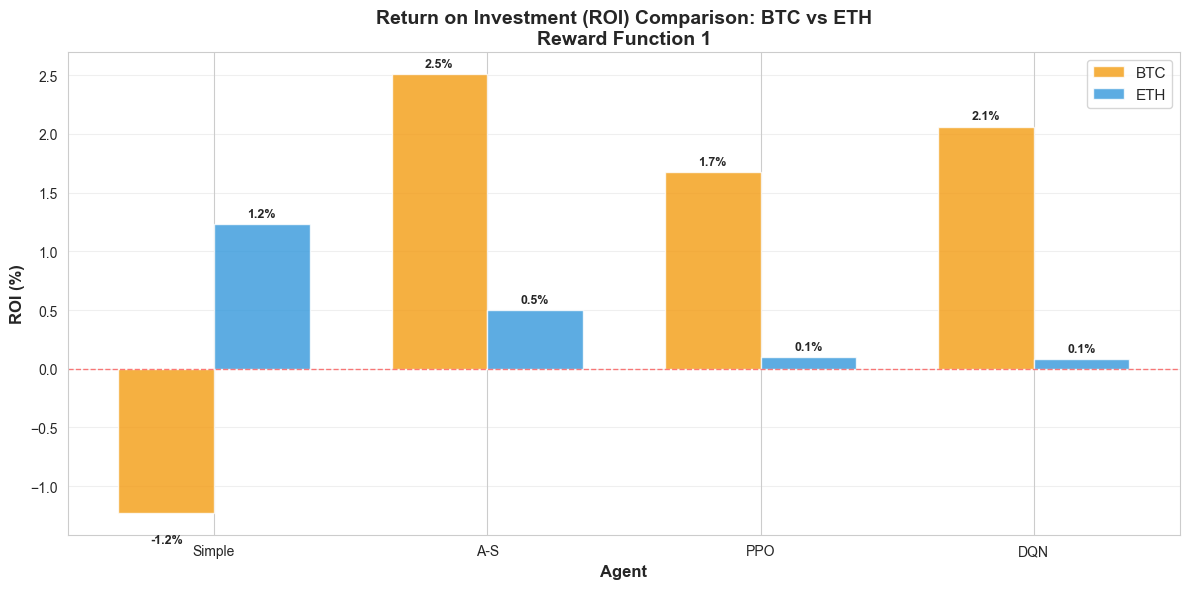

Figure saved: roi_comparison_reward1.png


In [ ]:
# Create ROI comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

agents = ['Simple', 'A-S', 'PPO', 'DQN']
btc_rois = [btc_reward1_results[agent]['metrics']['roi'] for agent in agents]
eth_rois = [eth_reward1_results[agent]['metrics']['roi'] for agent in agents]

x = np.arange(len(agents))
width = 0.35

bars1 = ax.bar(x - width/2, btc_rois, width, label='BTC', color='#f39c12', alpha=0.8)
bars2 = ax.bar(x + width/2, eth_rois, width, label='ETH', color='#3498db', alpha=0.8)

ax.set_xlabel('Agent', fontsize=12, fontweight='bold')
ax.set_ylabel('ROI (%)', fontsize=12, fontweight='bold')
ax.set_title('Return on Investment (ROI) Comparison: BTC vs ETH\nReward Function 1', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(agents)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9, fontweight='bold')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.savefig('roi_comparison_reward1.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: roi_comparison_reward1.png")

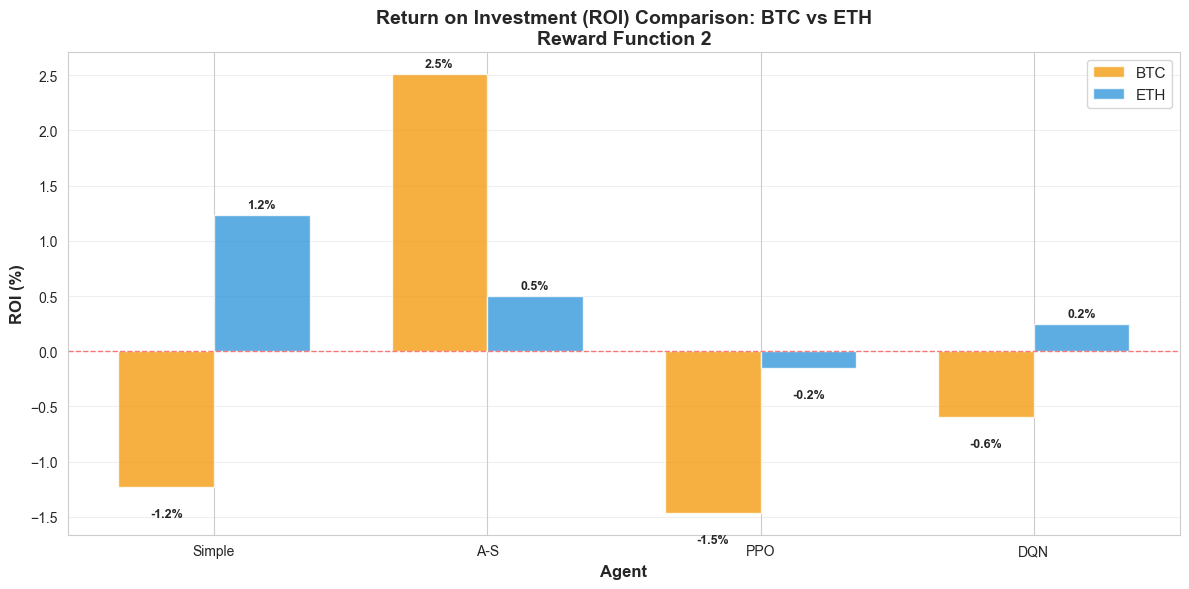

Figure saved: roi_comparison_reward2.png


In [ ]:
# Create ROI comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

agents = ['Simple', 'A-S', 'PPO', 'DQN']
btc_rois = [btc_reward2_results[agent]['metrics']['roi'] for agent in agents]
eth_rois = [eth_reward2_results[agent]['metrics']['roi'] for agent in agents]

x = np.arange(len(agents))
width = 0.35

bars1 = ax.bar(x - width/2, btc_rois, width, label='BTC', color='#f39c12', alpha=0.8)
bars2 = ax.bar(x + width/2, eth_rois, width, label='ETH', color='#3498db', alpha=0.8)

ax.set_xlabel('Agent', fontsize=12, fontweight='bold')
ax.set_ylabel('ROI (%)', fontsize=12, fontweight='bold')
ax.set_title('Return on Investment (ROI) Comparison: BTC vs ETH\nReward Function 2', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(agents)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9, fontweight='bold')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.savefig('roi_comparison_reward2.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: roi_comparison_reward2.png")

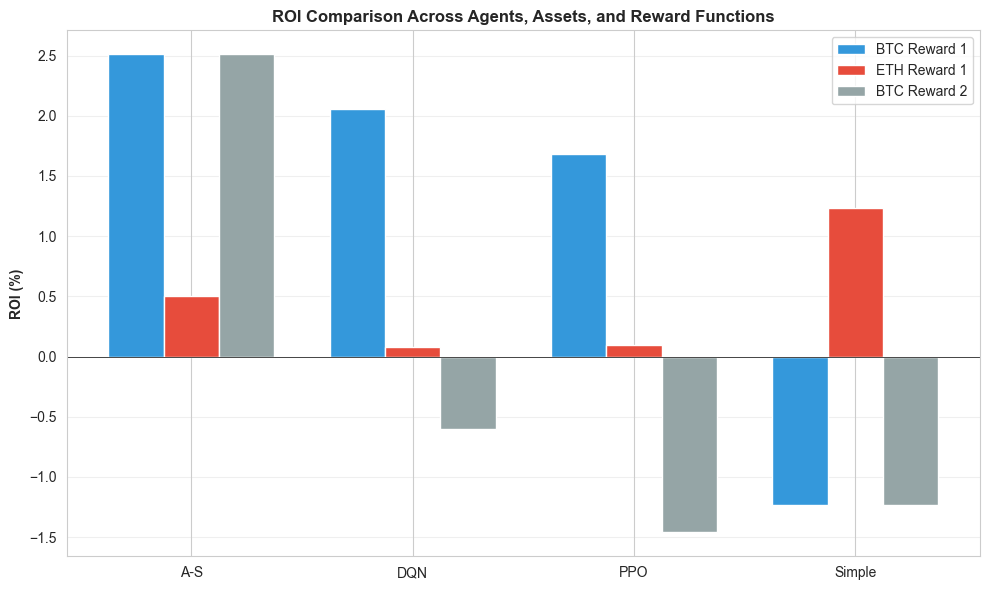

In [ ]:
# Combined ROI comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

agents = ['A-S', 'DQN', 'PPO', 'Simple']
btc_r1 = [2.51, 2.06, 1.68, -1.23]
eth_r1 = [0.50, 0.08, 0.10, 1.23]
btc_r2 = [2.51, -0.60, -1.46, -1.23]

x = np.arange(len(agents))
width = 0.25

bars1 = ax.bar(x - width, btc_r1, width, label='BTC Reward 1', color='#3498db')
bars2 = ax.bar(x, eth_r1, width, label='ETH Reward 1', color='#e74c3c')
bars3 = ax.bar(x + width, btc_r2, width, label='BTC Reward 2', color='#95a5a6')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('ROI (%)', fontweight='bold')
ax.set_title('ROI Comparison Across Agents, Assets, and Reward Functions', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(agents)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('roi_comparison_combined.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Key Findings and Insights

In [ ]:
# Generate automated insights
print("\n" + "="*100)
print("KEY FINDINGS REWARD FUNCTION 1")
print("="*100)

# Best performer per asset
for asset, results_dict in [('BTC', btc_reward1_results), ('ETH', eth_reward1_results)]:
    best_agent = max(results_dict.items(), key=lambda x: x[1]['metrics']['roi'])
    agent_name = best_agent[0]
    roi = best_agent[1]['metrics']['roi']
    
    print(f"\n{asset}:")
    print(f"  Best Performer:  {agent_name} (ROI: {roi:.2f}%)")
    
    # Profitability count
    profitable = sum(1 for r in results_dict.values() if r['metrics']['roi'] > 0)
    print(f"  Profitable Agents: {profitable}/4")
    
    # PPO vs A-S comparison
    ppo_roi = results_dict['PPO']['metrics']['roi']
    as_roi = results_dict['A-S']['metrics']['roi']
    diff = ppo_roi - as_roi
    
    print(f"  PPO vs A-S:    {diff:+.2f}% ({'PPO better' if diff > 0 else 'A-S better'})")

# Cross-asset insights
print("\nCross-Asset Insights:")
for agent in ['Simple', 'A-S', 'PPO', 'DQN']:
    btc_roi = btc_reward1_results[agent]['metrics']['roi']
    eth_roi = eth_reward1_results[agent]['metrics']['roi']
    diff = abs(btc_roi - eth_roi)
    
    consistency = "High" if diff < 2 else "Medium" if diff < 5 else "Low"
    print(f"  {agent:8s}: BTC {btc_roi:+6.2f}% | ETH {eth_roi:+6.2f}% | Diff: {diff:5.2f}% | Consistency: {consistency}")

print("\n" + "="*100)


KEY FINDINGS REWARD FUNCTION 1

BTC:
  Best Performer:  A-S (ROI: 2.51%)
  Profitable Agents: 3/4
  PPO vs A-S:    -0.83% (A-S better)

ETH:
  Best Performer:  Simple (ROI: 1.23%)
  Profitable Agents: 4/4
  PPO vs A-S:    -0.41% (A-S better)

Cross-Asset Insights:
  Simple  : BTC  -1.23% | ETH  +1.23% | Diff:  2.46% | Consistency: Medium
  A-S     : BTC  +2.51% | ETH  +0.50% | Diff:  2.01% | Consistency: Medium
  PPO     : BTC  +1.68% | ETH  +0.10% | Diff:  1.58% | Consistency: High
  DQN     : BTC  +2.06% | ETH  +0.08% | Diff:  1.98% | Consistency: High



In [ ]:
# Generate automated insights
print("\n" + "="*100)
print("KEY FINDINGS REWARD FUNCTION 2")
print("="*100)

# Best performer per asset
for asset, results_dict in [('BTC', btc_reward1_results), ('ETH', eth_reward2_results)]:
    best_agent = max(results_dict.items(), key=lambda x: x[1]['metrics']['roi'])
    agent_name = best_agent[0]
    roi = best_agent[1]['metrics']['roi']
    
    print(f"\n{asset}:")
    print(f"  Best Performer:  {agent_name} (ROI: {roi:.2f}%)")
    
    # Profitability count
    profitable = sum(1 for r in results_dict.values() if r['metrics']['roi'] > 0)
    print(f"  Profitable Agents: {profitable}/4")
    
    # PPO vs A-S comparison
    ppo_roi = results_dict['PPO']['metrics']['roi']
    as_roi = results_dict['A-S']['metrics']['roi']
    diff = ppo_roi - as_roi
    
    print(f"  PPO vs A-S:    {diff:+.2f}% ({'PPO better' if diff > 0 else 'A-S better'})")

# Cross-asset insights
print("\nCross-Asset Insights:")
for agent in ['Simple', 'A-S', 'PPO', 'DQN']:
    btc_roi = btc_reward1_results[agent]['metrics']['roi']
    eth_roi = eth_reward1_results[agent]['metrics']['roi']
    diff = abs(btc_roi - eth_roi)
    
    consistency = "High" if diff < 2 else "Medium" if diff < 5 else "Low"
    print(f"  {agent:8s}: BTC {btc_roi:+6.2f}% | ETH {eth_roi:+6.2f}% | Diff: {diff:5.2f}% | Consistency: {consistency}")

print("\n" + "="*100)


KEY FINDINGS REWARD FUNCTION 2

BTC:
  Best Performer:  A-S (ROI: 2.51%)
  Profitable Agents: 3/4
  PPO vs A-S:    -0.83% (A-S better)

ETH:
  Best Performer:  Simple (ROI: 1.23%)
  Profitable Agents: 3/4
  PPO vs A-S:    -0.66% (A-S better)

Cross-Asset Insights:
  Simple  : BTC  -1.23% | ETH  +1.23% | Diff:  2.46% | Consistency: Medium
  A-S     : BTC  +2.51% | ETH  +0.50% | Diff:  2.01% | Consistency: Medium
  PPO     : BTC  +1.68% | ETH  +0.10% | Diff:  1.58% | Consistency: High
  DQN     : BTC  +2.06% | ETH  +0.08% | Diff:  1.98% | Consistency: High



## 8. Best Performing Configuration

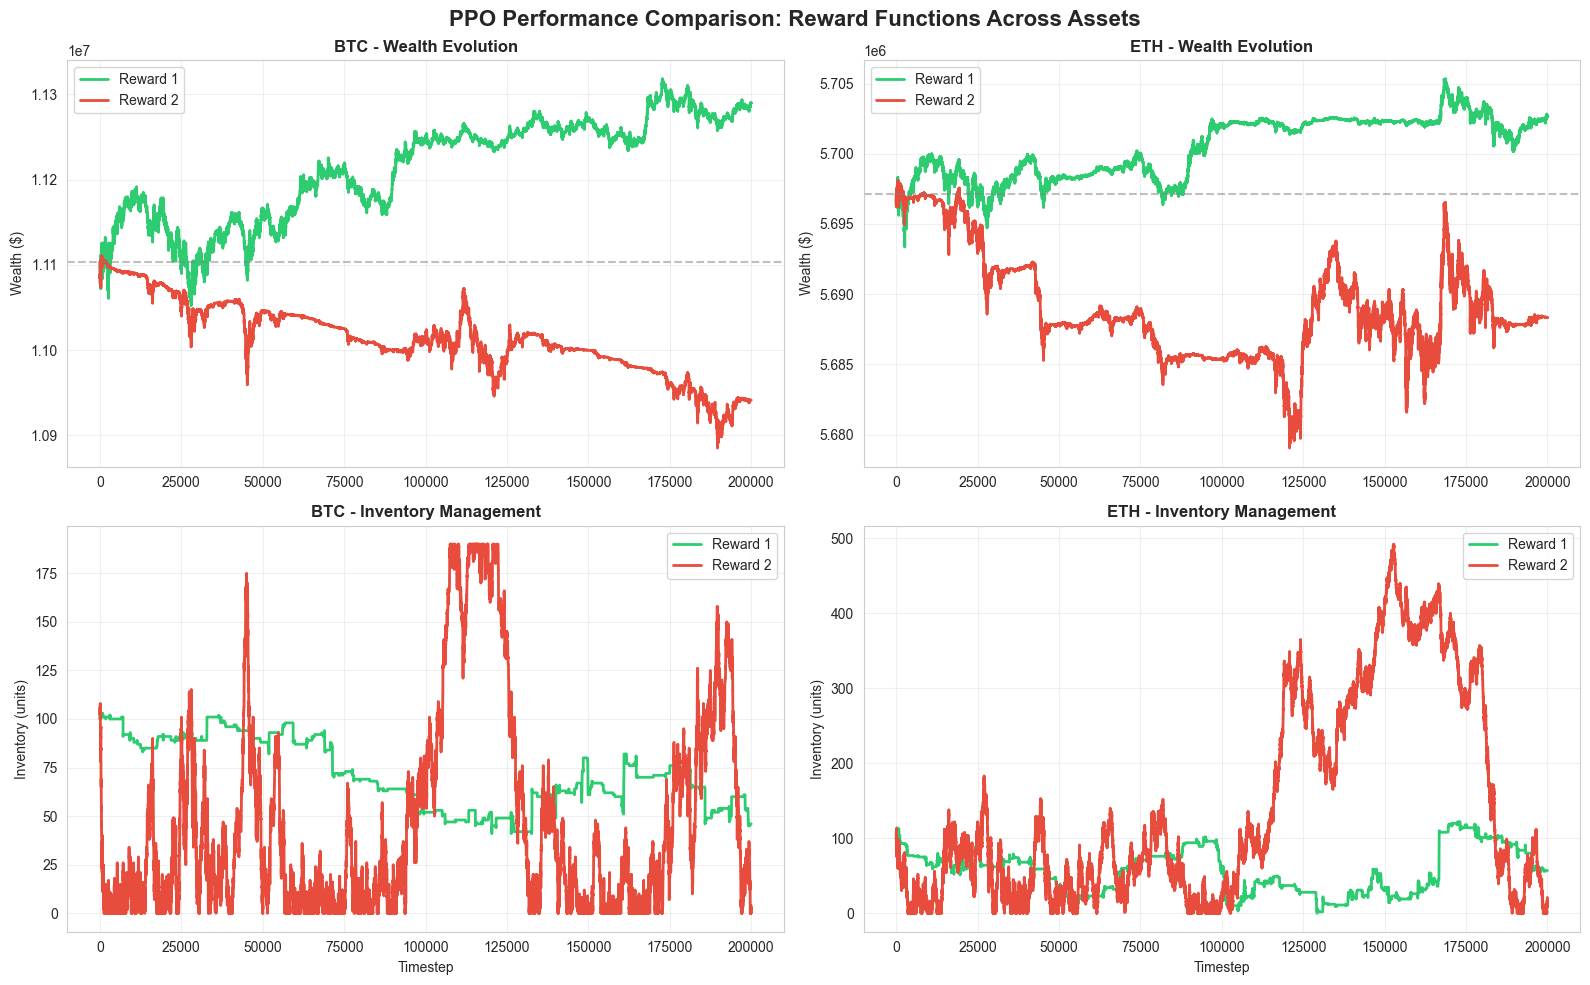

✓ Figure saved: ppo_reward_comparison.png


In [ ]:
# Compare PPO with both reward functions on both assets
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('PPO Performance Comparison: Reward Functions Across Assets', 
             fontsize=16, fontweight='bold')

configs = [
    ('BTC', btc_reward1_results['PPO'], btc_reward2_results['PPO']),
    ('ETH', eth_reward1_results['PPO'], eth_reward2_results['PPO'])
]

for col, (asset, r1, r2) in enumerate(configs):
    # Wealth comparison
    ax = axes[0, col]
    ax.plot(r1['results']['wealth'], label='Reward 1', color='#2ecc71', linewidth=2)
    ax.plot(r2['results']['wealth'], label='Reward 2', color='#e74c3c', linewidth=2)
    ax.axhline(y=r1['results']['wealth'][0], color='gray', linestyle='--', alpha=0.5)
    ax.set_title(f'{asset} - Wealth Evolution', fontweight='bold')
    ax.set_ylabel('Wealth ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Inventory comparison
    ax = axes[1, col]
    ax.plot(r1['results']['inventory'], label='Reward 1', color='#2ecc71', linewidth=2)
    ax.plot(r2['results']['inventory'], label='Reward 2', color='#e74c3c', linewidth=2)
    ax.set_title(f'{asset} - Inventory Management', fontweight='bold')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Inventory (units)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ppo_reward_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Figure saved: ppo_reward_comparison.png")

## 9. Export Results for Report

In [ ]:
# Save all key figures and data
import json

# Export summary statistics
summary = {
    'config': CONFIG,
    'btc_reward1': {agent: results['metrics'] for agent, results in btc_reward1_results.items()},
    'eth_reward1': {agent: results['metrics'] for agent, results in eth_reward1_results.items()},
    'btc_reward2': {agent: results['metrics'] for agent, results in btc_reward2_results.items()},
    'eth_reward2': {agent: results['metrics'] for agent, results in eth_reward2_results.items()}
}

with open('experiment_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(" Experiment summary saved: experiment_summary.json")
print("\nGenerated files:")
print("  - cross_asset_comparison_reward1.png")
print("  - roi_comparison_reward1.png")
print("  - ppo_reward_comparison.png")
print("  - performance_metrics_reward1.csv")
print("  - experiment_summary.json")
print("\n Analysis complete!")